In [3]:
import csv
import os
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from typing import Dict, List, Optional
import psycopg2
from pathlib import Path

try:
    import psycopg2
    from psycopg2.extras import RealDictCursor
except ImportError as exc:
    raise SystemExit(
        "psycopg2 is required. Install with: pip install psycopg2-binary"
    ) from exc


# Database Config

In [5]:
def conn_args_from_env() -> dict:
    return {
        "host": os.getenv("PGHOST", "localhost"),
        "port": int(os.getenv("PGPORT", "5432")),
        "dbname": os.getenv("PGDATABASE", "elt_dw"),
        "user": os.getenv("PGUSER", "elt_user"),
        "password": os.getenv("PGPASSWORD", "elt_pass"),
    }


### Buat Schema dan Table

In [4]:


schema_sql = [
    "CREATE SCHEMA IF NOT EXISTS raw;",
    "CREATE SCHEMA IF NOT EXISTS stg;",
    "CREATE SCHEMA IF NOT EXISTS gold;",
    "CREATE EXTENSION IF NOT EXISTS pgcrypto;",
]

table_sql = [
    "DROP TABLE IF EXISTS raw.weather_hourly_raw;",
    "DROP TABLE IF EXISTS raw.weather_location_raw;",
    "DROP TABLE IF EXISTS raw.flights_raw;",

    """
    CREATE TABLE raw.flights_raw (
        fl_date DATE,
        airline TEXT,
        airline_dot TEXT,
        airline_code TEXT,
        dot_code NUMERIC,
        fl_number NUMERIC,
        origin TEXT,
        origin_city TEXT,
        dest TEXT,
        dest_city TEXT,
        crs_dep_time NUMERIC,
        dep_time NUMERIC,
        dep_delay NUMERIC,
        taxi_out NUMERIC,
        wheels_off NUMERIC,
        wheels_on NUMERIC,
        taxi_in NUMERIC,
        crs_arr_time NUMERIC,
        arr_time NUMERIC,
        arr_delay NUMERIC,
        cancelled NUMERIC,
        cancellation_code TEXT,
        diverted NUMERIC,
        crs_elapsed_time NUMERIC,
        elapsed_time NUMERIC,
        air_time NUMERIC,
        distance NUMERIC,
        delay_due_carrier NUMERIC,
        delay_due_weather NUMERIC,
        delay_due_nas NUMERIC,
        delay_due_security NUMERIC,
        delay_due_late_aircraft NUMERIC
    );
    """,
    """
    CREATE TABLE raw.weather_location_raw (
        location_id            numeric PRIMARY KEY,
        latitude               numeric,
        longitude              numeric,
        elevation              numeric,
        utc_offset_seconds     numeric,
        timezone               text,
        timezone_abbreviation  text
    );
    """,
    """
    CREATE TABLE raw.weather_hourly_raw (
        location_id           numeric NOT NULL,
        time                  timestamp NOT NULL,
        temperature_2m        numeric,
        precipitation         numeric,
        rain                  numeric,
        snowfall              numeric,
        weather_code          numeric,
        surface_pressure      numeric,
        cloud_cover           numeric,
        cloud_cover_low       numeric,
        wind_speed_10m        numeric,
        wind_speed_100m       numeric,
        wind_direction_10m    numeric,
        wind_direction_100m   numeric,
        wind_gusts_10m        numeric,
        PRIMARY KEY (location_id, time),
        FOREIGN KEY (location_id) REFERENCES raw.weather_location_raw(location_id)
    );
    """,
]

with psycopg2.connect(**conn_args_from_env()) as conn:
    with conn.cursor() as cur:
        for stmt in schema_sql:
            cur.execute(stmt)
        for stmt in table_sql:
            cur.execute(stmt)
    conn.commit()


In [5]:
flights_path = Path("C:/flights_sample_3m.csv")
weather_location_path = Path("C:/Users/ryand/Pictures/BigDataPy/weather_location.csv")
weather_data_path = Path("C:/Users/ryand/Pictures/BigDataPy/weather_data.csv")

with psycopg2.connect(**conn_args_from_env()) as conn:
    with conn.cursor() as cur:
        cur.execute("DROP TABLE IF EXISTS raw.flights_raw_stage;")
        cur.execute("CREATE UNLOGGED TABLE raw.flights_raw_stage (LIKE raw.flights_raw INCLUDING ALL);")

        with flights_path.open("r", encoding="utf-8") as f:
            cur.copy_expert(
                "COPY raw.flights_raw_stage FROM STDIN WITH (FORMAT csv, HEADER true)",
                f,
            )

        cur.execute("TRUNCATE TABLE raw.flights_raw;")
        cur.execute(
            """
            WITH top_origin AS (
                SELECT origin_city
                FROM raw.flights_raw_stage
                GROUP BY origin_city
                ORDER BY COUNT(*) DESC
                LIMIT 10
            ),
            top_dest AS (
                SELECT dest_city
                FROM raw.flights_raw_stage
                GROUP BY dest_city
                ORDER BY COUNT(*) DESC
                LIMIT 10
            )
            INSERT INTO raw.flights_raw
            SELECT *
            FROM raw.flights_raw_stage
            WHERE origin_city IN (SELECT origin_city FROM top_origin)
              AND dest_city IN (SELECT dest_city FROM top_dest);
            """
        )

        cur.execute("DROP TABLE raw.flights_raw_stage;")

        with weather_location_path.open("r", encoding="utf-8") as f:
            cur.copy_expert(
                "COPY raw.weather_location_raw FROM STDIN WITH (FORMAT csv, HEADER true)",
                f,
            )
        with weather_data_path.open("r", encoding="utf-8") as f:
            cur.copy_expert(
                "COPY raw.weather_hourly_raw ("
                "location_id, time, temperature_2m, precipitation, rain, snowfall, weather_code, "
                "surface_pressure, cloud_cover, cloud_cover_low, wind_speed_10m, wind_speed_100m, "
                "wind_direction_10m, wind_direction_100m, wind_gusts_10m"
                ") FROM STDIN WITH (FORMAT csv, HEADER true)",
                f,
            )
    conn.commit()


### Metadata

In [123]:
tables = [
    ("raw", "flights_raw"),
    ("raw", "weather_location_raw"),
    ("raw", "weather_hourly_raw"),
]

rows = []

with psycopg2.connect(**conn_args_from_env()) as conn:
    for schema, table in tables:
        cols_df = pd.read_sql_query(
            f"""
            SELECT column_name, data_type
            FROM information_schema.columns
            WHERE table_schema = '{schema}'
              AND table_name = '{table}'
            ORDER BY ordinal_position;
            """,
            conn
        )

        total_rows = pd.read_sql_query(
            f"SELECT COUNT(*) AS total_rows FROM {schema}.{table}",
            conn
        ).at[0, "total_rows"]

        cols = cols_df["column_name"].tolist()
        missing_exprs = [
            f'SUM(CASE WHEN "{c}" IS NULL THEN 1 ELSE 0 END) AS "{c}"'
            for c in cols
        ]
        missing_query = "SELECT " + ", ".join(missing_exprs) + f" FROM {schema}.{table}"
        missing_counts = pd.read_sql_query(missing_query, conn).iloc[0].to_dict()

        for _, r in cols_df.iterrows():
            col = r["column_name"]
            dtype = r["data_type"]
            miss = int(missing_counts.get(col, 0))
            miss_pct = (miss / total_rows * 100) if total_rows else 0.0

            rows.append({
                "table_schema": schema,
                "table_name": table,
                "column_name": col,
                "data_type": dtype,
                "row_count": int(total_rows),
                "missing_count": miss,
                "missing_pct": round(miss_pct, 4),
            })

metadata_df = pd.DataFrame(rows)
metadata_df


C:\Users\ryand\AppData\Local\Temp\ipykernel_5360\1866166817.py:11: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  cols_df = pd.read_sql_query(
C:\Users\ryand\AppData\Local\Temp\ipykernel_5360\1866166817.py:22: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  total_rows = pd.read_sql_query(
C:\Users\ryand\AppData\Local\Temp\ipykernel_5360\1866166817.py:33: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  missing_counts = pd.read_sql_query(missing_query, conn).iloc[0].to_dict()


,table_schema,table_name,column_name,data_type,row_count,missing_count,missing_pct
0,raw,flights_raw,fl_date,date,255812,0,0.0000
1,raw,flights_raw,airline,text,255812,0,0.0000
2,raw,flights_raw,airline_dot,text,255812,0,0.0000
3,raw,flights_raw,airline_code,text,255812,0,0.0000
4,raw,flights_raw,dot_code,numeric,255812,0,0.0000
5,raw,flights_raw,fl_number,numeric,255812,0,0.0000
6,raw,flights_raw,origin,text,255812,0,0.0000
7,raw,flights_raw,origin_city,text,255812,0,0.0000
8,raw,flights_raw,dest,text,255812,0,0.0000
9,raw,flights_raw,dest_city,text,255812,0,0.0000


# Cleaning

## Cleaning Flights_raw

In [6]:
with psycopg2.connect(**conn_args_from_env()) as conn:
    with conn.cursor() as cur:
        cur.execute("CREATE SCHEMA IF NOT EXISTS stg;")
        cur.execute("DROP TABLE IF EXISTS stg.flights_cleaned;")
        cur.execute("CREATE TABLE stg.flights_cleaned AS SELECT * FROM raw.flights_raw;")
    conn.commit()


In [7]:
query = "SELECT * FROM raw.flights_raw"
with psycopg2.connect(**conn_args_from_env()) as conn:
    df = pd.read_sql_query(query, conn)

df.head(3)

C:\Users\ryand\AppData\Local\Temp\ipykernel_5360\2237596341.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


,fl_date,airline,airline_dot,airline_code,dot_code,fl_number,origin,origin_city,dest,dest_city,...,diverted,crs_elapsed_time,elapsed_time,air_time,distance,delay_due_carrier,delay_due_weather,delay_due_nas,delay_due_security,delay_due_late_aircraft
0,2023-02-12,Spirit Air Lines,Spirit Air Lines: NK,NK,20416.0,590.0,IAH,"Houston, TX",LAX,"Los Angeles, CA",...,0.0,227.0,219.0,200.0,1379.0,NaN,NaN,NaN,NaN,NaN
1,2019-03-24,Spirit Air Lines,Spirit Air Lines: NK,NK,20416.0,906.0,DEN,"Denver, CO",IAH,"Houston, TX",...,0.0,148.0,139.0,110.0,862.0,NaN,NaN,NaN,NaN,NaN
2,2019-04-23,United Air Lines Inc.,United Air Lines Inc.: UA,UA,19977.0,498.0,ORD,"Chicago, IL",IAD,"Washington, DC",...,0.0,110.0,106.0,80.0,588.0,NaN,NaN,NaN,NaN,NaN


In [8]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 255812 entries, 0 to 255811
Data columns (total 32 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   fl_date                  255812 non-null  object 
 1   airline                  255812 non-null  object 
 2   airline_dot              255812 non-null  object 
 3   airline_code             255812 non-null  object 
 4   dot_code                 255812 non-null  float64
 5   fl_number                255812 non-null  float64
 6   origin                   255812 non-null  object 
 7   origin_city              255812 non-null  object 
 8   dest                     255812 non-null  object 
 9   dest_city                255812 non-null  object 
 10  crs_dep_time             255812 non-null  float64
 11  dep_time                 248958 non-null  float64
 12  dep_delay                248958 non-null  float64
 13  taxi_out                 248817 non-null  float64
 14  whee

In [9]:
df.shape[0]


255812

### Drop unnecessary column

In [11]:
with psycopg2.connect(**conn_args_from_env()) as conn:
    with conn.cursor() as cur:
        cur.execute(
            """
            SELECT 1
            FROM information_schema.columns
            WHERE table_schema = 'stg'
              AND table_name = 'flights_cleaned'
              AND column_name = 'airline_dot';
            """
        )
        exists = cur.fetchone() is not None

        if exists:
            cur.execute('ALTER TABLE stg.flights_cleaned DROP COLUMN airline_dot;')
        else:
            print("not exist")
    conn.commit()

with psycopg2.connect(**conn_args_from_env()) as conn:
    df = pd.read_sql_query("SELECT * FROM stg.flights_cleaned", conn)

df.head(3)


C:\Users\ryand\AppData\Local\Temp\ipykernel_5360\673072018.py:21: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query("SELECT * FROM stg.flights_cleaned", conn)


,fl_date,airline,airline_code,dot_code,fl_number,origin,origin_city,dest,dest_city,crs_dep_time,...,diverted,crs_elapsed_time,elapsed_time,air_time,distance,delay_due_carrier,delay_due_weather,delay_due_nas,delay_due_security,delay_due_late_aircraft
0,2023-02-12,Spirit Air Lines,NK,20416.0,590.0,IAH,"Houston, TX",LAX,"Los Angeles, CA",530.0,...,0.0,227.0,219.0,200.0,1379.0,NaN,NaN,NaN,NaN,NaN
1,2019-03-24,Spirit Air Lines,NK,20416.0,906.0,DEN,"Denver, CO",IAH,"Houston, TX",1530.0,...,0.0,148.0,139.0,110.0,862.0,NaN,NaN,NaN,NaN,NaN
2,2019-04-23,United Air Lines Inc.,UA,19977.0,498.0,ORD,"Chicago, IL",IAD,"Washington, DC",1330.0,...,0.0,110.0,106.0,80.0,588.0,NaN,NaN,NaN,NaN,NaN


### Check missing values


In [12]:
with psycopg2.connect(**conn_args_from_env()) as conn:
    cols_df = pd.read_sql_query(
        """
        SELECT column_name
        FROM information_schema.columns
        WHERE table_schema = 'stg'
          AND table_name = 'flights_cleaned'
        ORDER BY ordinal_position;
        """,
        conn
    )
    cols = cols_df["column_name"].tolist()

missing_exprs = []
for col in cols:
    col_escaped = col.replace('"', '""')
    missing_exprs.append(
        f'SUM(CASE WHEN "{col_escaped}" IS NULL THEN 1 ELSE 0 END) AS "{col_escaped}__missing"'
    )

query = (
    "SELECT COUNT(*) AS total_rows,\n"
    + ",\n".join(missing_exprs)
    + "\nFROM stg.flights_cleaned"
)

with psycopg2.connect(**conn_args_from_env()) as conn:
    missing_raw = pd.read_sql_query(query, conn)

total_rows = missing_raw.at[0, "total_rows"]

missing_info = missing_raw.drop(columns=["total_rows"]).T
missing_info.columns = ["Missing Count"]
missing_info["Missing Percentage"] = (missing_info["Missing Count"] / total_rows) * 100
missing_info.index = missing_info.index.str.replace("__missing", "", regex=False)

print("Missing Values in Flight Data:")
print(
    missing_info[missing_info["Missing Count"] > 0]
    .sort_values(by="Missing Count", ascending=False)
)


Missing Values in Flight Data:
                         Missing Count  Missing Percentage
cancellation_code               248808           97.262052
delay_due_carrier               208255           81.409394
delay_due_weather               208255           81.409394
delay_due_nas                   208255           81.409394
delay_due_security              208255           81.409394
delay_due_late_aircraft         208255           81.409394
arr_delay                         7697            3.008850
elapsed_time                      7697            3.008850
air_time                          7697            3.008850
wheels_on                         7053            2.757103
taxi_in                           7053            2.757103
arr_time                          7053            2.757103
taxi_out                          6995            2.734430
wheels_off                        6995            2.734430
dep_time                          6854            2.679311
dep_delay                

C:\Users\ryand\AppData\Local\Temp\ipykernel_5360\4171802302.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  cols_df = pd.read_sql_query(
C:\Users\ryand\AppData\Local\Temp\ipykernel_5360\4171802302.py:28: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  missing_raw = pd.read_sql_query(query, conn)


### Handling Missing Value

#### Remove column

In [13]:
# Column ini (cancelation_code) di hapus karena arti dari code itu sendiri tidak bisa dijelaskan dan tidak ada sumber yang dapat mendukung data dari code tersebut 
# sehingga kami memutuskan untuk menghapusnya saja.

with psycopg2.connect(**conn_args_from_env()) as conn:
    with conn.cursor() as cur:
        cur.execute(
            """
            SELECT column_name
            FROM information_schema.columns
            WHERE table_schema = 'stg'
              AND table_name = 'flights_cleaned'
            ORDER BY ordinal_position;
            """
        )
        cols = [r[0] for r in cur.fetchall()]

        if "cancellation_code" in cols:
            cols = [c for c in cols if c != "cancellation_code"]
            print("Column 'cancellation_code' has been dropped.")
        else:
            print("Column 'cancellation_code' not found.")

        cols_sql = ", ".join(f'"{c}"' for c in cols)
        cur.execute("DROP TABLE IF EXISTS stg.flights_cleaned;")
        cur.execute(f"CREATE TABLE stg.flights_cleaned AS SELECT {cols_sql} FROM stg.flights_cleaned;")
    conn.commit()

with psycopg2.connect(**conn_args_from_env()) as conn:
    df = pd.read_sql_query("SELECT * FROM stg.flights_cleaned", conn)

Column 'cancellation_code' has been dropped.


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 255812 entries, 0 to 255811
Data columns (total 31 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   fl_date                  255812 non-null  object 
 1   airline                  255812 non-null  object 
 2   airline_code             255812 non-null  object 
 3   dot_code                 255812 non-null  float64
 4   fl_number                255812 non-null  float64
 5   origin                   255812 non-null  object 
 6   origin_city              255812 non-null  object 
 7   dest                     255812 non-null  object 
 8   dest_city                255812 non-null  object 
 9   crs_dep_time             255812 non-null  float64
 10  dep_time                 248958 non-null  float64
 11  dep_delay                248958 non-null  float64
 12  taxi_out                 248817 non-null  float64
 13  wheels_off               248817 non-null  float64
 14  whee

#### Imputation missing value

In [15]:
delay_columns = [
    "delay_due_carrier",
    "delay_due_weather",
    "delay_due_nas",
    "delay_due_security",
    "delay_due_late_aircraft",
]

set_clause = ", ".join([f'"{c}" = COALESCE("{c}", 0)' for c in delay_columns])

with psycopg2.connect(**conn_args_from_env()) as conn:
    with conn.cursor() as cur:
        cur.execute(f'UPDATE stg.flights_cleaned SET {set_clause};')
    conn.commit()

with psycopg2.connect(**conn_args_from_env()) as conn:
    df = pd.read_sql_query("SELECT * FROM stg.flights_cleaned", conn)

df.head()


C:\Users\ryand\AppData\Local\Temp\ipykernel_5360\1152915047.py:17: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query("SELECT * FROM stg.flights_cleaned", conn)


,fl_date,airline,airline_code,dot_code,fl_number,origin,origin_city,dest,dest_city,crs_dep_time,...,diverted,crs_elapsed_time,elapsed_time,air_time,distance,delay_due_carrier,delay_due_weather,delay_due_nas,delay_due_security,delay_due_late_aircraft
0,2019-04-14,Southwest Airlines Co.,WN,19393.0,4265.0,LGA,"New York, NY",ATL,"Atlanta, GA",745.0,...,0.0,150.0,NaN,NaN,762.0,0.0,0.0,0.0,0.0,0.0
1,2021-08-06,Spirit Air Lines,NK,20416.0,130.0,LAX,"Los Angeles, CA",DFW,"Dallas/Fort Worth, TX",2359.0,...,0.0,182.0,NaN,NaN,1235.0,0.0,0.0,0.0,0.0,0.0
2,2019-09-20,American Airlines Inc.,AA,19805.0,1264.0,IAH,"Houston, TX",DFW,"Dallas/Fort Worth, TX",1032.0,...,0.0,81.0,NaN,NaN,224.0,0.0,0.0,0.0,0.0,0.0
3,2022-06-28,Delta Air Lines Inc.,DL,19790.0,2558.0,IAD,"Washington, DC",ATL,"Atlanta, GA",600.0,...,0.0,103.0,NaN,NaN,534.0,0.0,0.0,0.0,0.0,0.0
4,2020-03-27,Mesa Airlines Inc.,YV,20378.0,6011.0,IAD,"Washington, DC",CLT,"Charlotte, NC",1725.0,...,0.0,99.0,NaN,NaN,322.0,0.0,0.0,0.0,0.0,0.0


In [16]:
selected_columns = [
    "fl_date","airline","origin_city","dest_city","crs_dep_time","dep_time",
    "dep_delay","taxi_out","wheels_off","wheels_on","taxi_in","crs_arr_time",
    "arr_time","arr_delay","air_time","cancelled","delay_due_carrier",
    "delay_due_weather","delay_due_nas","delay_due_security","delay_due_late_aircraft",
]

cols_sql = ", ".join(f'"{c}"' for c in selected_columns)
query = f"""
SELECT {cols_sql}
FROM stg.flights_cleaned
WHERE delay_due_weather > 0
"""

with psycopg2.connect(**conn_args_from_env()) as conn:
    filtered_delays = pd.read_sql_query(query, conn)

print("Baris data dengan DELAY_DUE_WEATHER > 0:")
filtered_delays.head()


Baris data dengan DELAY_DUE_WEATHER > 0:


C:\Users\ryand\AppData\Local\Temp\ipykernel_5360\3567406347.py:16: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  filtered_delays = pd.read_sql_query(query, conn)


,fl_date,airline,origin_city,dest_city,crs_dep_time,dep_time,dep_delay,taxi_out,wheels_off,wheels_on,...,crs_arr_time,arr_time,arr_delay,air_time,cancelled,delay_due_carrier,delay_due_weather,delay_due_nas,delay_due_security,delay_due_late_aircraft
0,2019-10-29,Southwest Airlines Co.,"Denver, CO","Washington, DC",800.0,846.0,46.0,44.0,930.0,1407.0,...,1320.0,1411.0,51.0,157.0,0.0,0.0,34.0,5.0,0.0,12.0
1,2022-11-19,Envoy Air,"Chicago, IL","Atlanta, GA",1320.0,1359.0,39.0,63.0,1502.0,1731.0,...,1629.0,1736.0,67.0,89.0,0.0,0.0,35.0,28.0,0.0,4.0
2,2019-02-01,JetBlue Airways,"New York, NY","Atlanta, GA",739.0,1001.0,142.0,20.0,1021.0,1225.0,...,1020.0,1235.0,135.0,124.0,0.0,0.0,135.0,0.0,0.0,0.0
3,2023-08-17,American Airlines Inc.,"Chicago, IL","Phoenix, AZ",820.0,842.0,22.0,23.0,905.0,1007.0,...,1002.0,1023.0,21.0,182.0,0.0,0.0,21.0,0.0,0.0,0.0
4,2023-01-30,Spirit Air Lines,"Dallas/Fort Worth, TX","Los Angeles, CA",1640.0,2023.0,223.0,82.0,2145.0,2241.0,...,1808.0,2248.0,280.0,176.0,0.0,0.0,8.0,57.0,0.0,215.0


Kolom dengan missing value terbanyak selanjutnya adalah kolom

*   DELAY_DUE_CARRIER
*   DELAY_DUE_WEATHER
*   DELAY_DUE_NAS
*   DELAY_DUE_SECURITY
*   DELAY_DUE_LATE_AIRCRAFT

Melihat beberapa baris data di atas, kolom ARR_DELAY (Delay kedatangan pesawat) merupakan hasil penjumlahan kelima kolom delay tersebut. Nilai negatif menunjukkan pesawat datang lebih cepat dari perkiraan, sehingga kami isi nilai NaN pada kelima kolom delay tersebut dengan nilai 0. Hal yang sama juga diterapkan jika penerbangannya di-cancel (ARR_TIME = NaN).


In [ ]:
delay_columns = [
    "delay_due_carrier",
    "delay_due_weather",
    "delay_due_nas",
    "delay_due_security",
    "delay_due_late_aircraft",
]

set_clause = ", ".join([f'"{c}" = COALESCE("{c}", 0)' for c in delay_columns])

with psycopg2.connect(**conn_args_from_env()) as conn:
    with conn.cursor() as cur:
        cur.execute(f'UPDATE stg.flights_cleaned SET {set_clause};')
    conn.commit()

# cek missing untuk kolom delay
missing_exprs = ", ".join(
    [f'SUM(CASE WHEN "{c}" IS NULL THEN 1 ELSE 0 END) AS "{c}"' for c in delay_columns]
)

query = f"SELECT {missing_exprs} FROM stg.flights_cleaned"

with psycopg2.connect(**conn_args_from_env()) as conn:
    missing_counts = pd.read_sql_query(query, conn)

print("Missing values in delay columns after filling all NaNs with 0:")
print(missing_counts.T)


Missing values in delay columns after filling all NaNs with 0:
                         0
delay_due_carrier        0
delay_due_weather        0
delay_due_nas            0
delay_due_security       0
delay_due_late_aircraft  0


C:\Users\ryand\AppData\Local\Temp\ipykernel_5360\355553389.py:24: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  missing_counts = pd.read_sql_query(query, conn)


In [18]:
cols_sql = ", ".join(f'"{c}"' for c in selected_columns)
query = f"SELECT {cols_sql} FROM stg.flights_cleaned"

with psycopg2.connect(**conn_args_from_env()) as conn:
    df = pd.read_sql_query(query, conn)

df.head()


C:\Users\ryand\AppData\Local\Temp\ipykernel_5360\1054912023.py:5: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


,fl_date,airline,origin_city,dest_city,crs_dep_time,dep_time,dep_delay,taxi_out,wheels_off,wheels_on,...,crs_arr_time,arr_time,arr_delay,air_time,cancelled,delay_due_carrier,delay_due_weather,delay_due_nas,delay_due_security,delay_due_late_aircraft
0,2020-03-30,Delta Air Lines Inc.,"Washington, DC","Atlanta, GA",1758.0,1753.0,-5.0,7.0,1800.0,1928.0,...,2001.0,1933.0,-28.0,88.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2019-03-07,Delta Air Lines Inc.,"Atlanta, GA","Dallas/Fort Worth, TX",1215.0,1227.0,12.0,12.0,1239.0,1335.0,...,1344.0,1343.0,-1.0,116.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2022-09-13,American Airlines Inc.,"New York, NY","Chicago, IL",1030.0,1232.0,122.0,12.0,1244.0,1329.0,...,1208.0,1343.0,95.0,105.0,0.0,0.0,0.0,0.0,0.0,95.0
3,2023-07-02,SkyWest Airlines Inc.,"New York, NY","Washington, DC",1455.0,1457.0,2.0,18.0,1515.0,1559.0,...,1627.0,1608.0,-19.0,44.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2023-01-06,Delta Air Lines Inc.,"New York, NY","Houston, TX",835.0,829.0,-6.0,18.0,847.0,1116.0,...,1209.0,1127.0,-42.0,209.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
filtered_delays.head()


,fl_date,airline,origin_city,dest_city,crs_dep_time,dep_time,dep_delay,taxi_out,wheels_off,wheels_on,...,crs_arr_time,arr_time,arr_delay,air_time,cancelled,delay_due_carrier,delay_due_weather,delay_due_nas,delay_due_security,delay_due_late_aircraft
0,2019-10-29,Southwest Airlines Co.,"Denver, CO","Washington, DC",800.0,846.0,46.0,44.0,930.0,1407.0,...,1320.0,1411.0,51.0,157.0,0.0,0.0,34.0,5.0,0.0,12.0
1,2022-11-19,Envoy Air,"Chicago, IL","Atlanta, GA",1320.0,1359.0,39.0,63.0,1502.0,1731.0,...,1629.0,1736.0,67.0,89.0,0.0,0.0,35.0,28.0,0.0,4.0
2,2019-02-01,JetBlue Airways,"New York, NY","Atlanta, GA",739.0,1001.0,142.0,20.0,1021.0,1225.0,...,1020.0,1235.0,135.0,124.0,0.0,0.0,135.0,0.0,0.0,0.0
3,2023-08-17,American Airlines Inc.,"Chicago, IL","Phoenix, AZ",820.0,842.0,22.0,23.0,905.0,1007.0,...,1002.0,1023.0,21.0,182.0,0.0,0.0,21.0,0.0,0.0,0.0
4,2023-01-30,Spirit Air Lines,"Dallas/Fort Worth, TX","Los Angeles, CA",1640.0,2023.0,223.0,82.0,2145.0,2241.0,...,1808.0,2248.0,280.0,176.0,0.0,0.0,8.0,57.0,0.0,215.0


In [20]:
with psycopg2.connect(**conn_args_from_env()) as conn:
    cols_df = pd.read_sql_query(
        """
        SELECT column_name
        FROM information_schema.columns
        WHERE table_schema = 'stg'
          AND table_name = 'flights_cleaned'
        ORDER BY ordinal_position;
        """,
        conn
    )
    cols = cols_df["column_name"].tolist()

missing_exprs = []
for col in cols:
    col_escaped = col.replace('"', '""')
    missing_exprs.append(
        f'SUM(CASE WHEN "{col_escaped}" IS NULL THEN 1 ELSE 0 END) AS "{col_escaped}"'
    )

query = "SELECT " + ", ".join(missing_exprs) + " FROM stg.flights_cleaned"

with psycopg2.connect(**conn_args_from_env()) as conn:
    missing_counts = pd.read_sql_query(query, conn)

missing_counts.T


C:\Users\ryand\AppData\Local\Temp\ipykernel_5360\1879294157.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  cols_df = pd.read_sql_query(
C:\Users\ryand\AppData\Local\Temp\ipykernel_5360\1879294157.py:24: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  missing_counts = pd.read_sql_query(query, conn)


,0
fl_date,0
airline,0
airline_code,0
dot_code,0
fl_number,0
origin,0
origin_city,0
dest,0
dest_city,0
crs_dep_time,0


#### Dropping missing value

In [21]:
with psycopg2.connect(**conn_args_from_env()) as conn:
    cols_df = pd.read_sql_query(
        """
        SELECT column_name
        FROM information_schema.columns
        WHERE table_schema = 'stg'
          AND table_name = 'flights_cleaned'
        ORDER BY ordinal_position;
        """,
        conn
    )
    cols = cols_df["column_name"].tolist()

missing_exprs = []
for col in cols:
    col_escaped = col.replace('"', '""')
    missing_exprs.append(
        f'SUM(CASE WHEN "{col_escaped}" IS NULL THEN 1 ELSE 0 END) AS "{col_escaped}"'
    )

query = "SELECT " + ", ".join(missing_exprs) + " FROM stg.flights_cleaned"

with psycopg2.connect(**conn_args_from_env()) as conn:
    missing_counts = pd.read_sql_query(query, conn)

missing_counts.T


C:\Users\ryand\AppData\Local\Temp\ipykernel_5360\1879294157.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  cols_df = pd.read_sql_query(
C:\Users\ryand\AppData\Local\Temp\ipykernel_5360\1879294157.py:24: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  missing_counts = pd.read_sql_query(query, conn)


,0
fl_date,0
airline,0
airline_code,0
dot_code,0
fl_number,0
origin,0
origin_city,0
dest,0
dest_city,0
crs_dep_time,0


Setelah melakukan imputasi untuk kolom DELAY_DUE, terdapat perbedaan jumlah missing value pada kolom DEPARTURE dan ARRIVAL. Data DEPARTURE memiliki missing value yang lebihs edikit daripada ARRIVAL. Kami berasumsi bahwa terdapat data penerbangan yang tidak dicancel, tetapi data kolom DEP_TIME, DEP_DELAY, TAXI_OUT, WHEELS_OFF ada yang missing. Kami bandingkan dengan data ARRIVAL, yaitu WHEELS_ON, TAXI_IN, ARR_TIME, ARR_DELAY, AIR_TIME, dan ELAPSED_TIME.

In [22]:
missing_time_columns = [
    "dep_time",
    "dep_delay",
    "taxi_out",
    "wheels_off",
    "wheels_on",
    "taxi_in",
    "arr_time",
    "arr_delay",
    "air_time",
    "elapsed_time",
]

selected_columns = [
    "fl_date","airline","origin_city","dest_city","crs_dep_time","dep_time",
    "dep_delay","taxi_out","wheels_off","wheels_on","taxi_in","crs_arr_time",
    "arr_time","arr_delay","air_time","cancelled","delay_due_carrier",
    "delay_due_weather","delay_due_nas","delay_due_security","delay_due_late_aircraft",
]

missing_predicates = " OR ".join([f'"{c}" IS NULL' for c in missing_time_columns])
select_cols_sql = ", ".join(f'"{c}"' for c in selected_columns)

count_query = f"""
SELECT COUNT(*) AS cnt
FROM stg.flights_cleaned
WHERE cancelled = 0
  AND ({missing_predicates})
"""

data_query = f"""
SELECT {select_cols_sql}
FROM stg.flights_cleaned
WHERE cancelled = 0
  AND ({missing_predicates})
"""

with psycopg2.connect(**conn_args_from_env()) as conn:
    count_df = pd.read_sql_query(count_query, conn)
    df = pd.read_sql_query(data_query, conn)

print(f"Total baris yang memenuhi kriteria: {int(count_df.at[0, 'cnt'])}")
df.head()


Total baris yang memenuhi kriteria: 693


C:\Users\ryand\AppData\Local\Temp\ipykernel_5360\805702091.py:39: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  count_df = pd.read_sql_query(count_query, conn)
C:\Users\ryand\AppData\Local\Temp\ipykernel_5360\805702091.py:40: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(data_query, conn)


,fl_date,airline,origin_city,dest_city,crs_dep_time,dep_time,dep_delay,taxi_out,wheels_off,wheels_on,...,crs_arr_time,arr_time,arr_delay,air_time,cancelled,delay_due_carrier,delay_due_weather,delay_due_nas,delay_due_security,delay_due_late_aircraft
0,2020-02-04,American Airlines Inc.,"Atlanta, GA","Dallas/Fort Worth, TX",700.0,652.0,-8.0,12.0,704.0,1100.0,...,836.0,1120.0,None,None,0.0,0.0,0.0,0.0,0.0,0.0
1,2019-06-17,SkyWest Airlines Inc.,"Chicago, IL","Washington, DC",1700.0,1655.0,-5.0,18.0,1713.0,2344.0,...,2011.0,2348.0,None,None,0.0,0.0,0.0,0.0,0.0,0.0
2,2019-07-02,Southwest Airlines Co.,"Denver, CO","Chicago, IL",1830.0,2122.0,172.0,11.0,2133.0,NaN,...,2155.0,NaN,None,None,0.0,0.0,0.0,0.0,0.0,0.0
3,2019-09-23,Delta Air Lines Inc.,"Atlanta, GA","Phoenix, AZ",1851.0,1853.0,2.0,12.0,1905.0,2217.0,...,1945.0,2240.0,None,None,0.0,0.0,0.0,0.0,0.0,0.0
4,2019-06-16,United Air Lines Inc.,"Chicago, IL","Houston, TX",1410.0,1417.0,7.0,48.0,1505.0,2017.0,...,1706.0,2134.0,None,None,0.0,0.0,0.0,0.0,0.0,0.0


### Drop inconsistent rows

In [23]:
missing_predicates = " OR ".join([f'"{c}" IS NULL' for c in missing_time_columns])

delete_query = f"""
DELETE FROM stg.flights_cleaned
WHERE cancelled = 0
  AND ({missing_predicates})
"""

with psycopg2.connect(**conn_args_from_env()) as conn:
    with conn.cursor() as cur:
        cur.execute(delete_query)
    conn.commit()

with psycopg2.connect(**conn_args_from_env()) as conn:
    df = pd.read_sql_query("SELECT * FROM stg.flights_cleaned", conn)

df.head()


C:\Users\ryand\AppData\Local\Temp\ipykernel_5360\4080618553.py:15: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query("SELECT * FROM stg.flights_cleaned", conn)


,fl_date,airline,airline_code,dot_code,fl_number,origin,origin_city,dest,dest_city,crs_dep_time,...,diverted,crs_elapsed_time,elapsed_time,air_time,distance,delay_due_carrier,delay_due_weather,delay_due_nas,delay_due_security,delay_due_late_aircraft
0,2020-03-30,Delta Air Lines Inc.,DL,19790.0,2238.0,DCA,"Washington, DC",ATL,"Atlanta, GA",1758.0,...,0.0,123.0,100.0,88.0,547.0,0.0,0.0,0.0,0.0,0.0
1,2019-03-07,Delta Air Lines Inc.,DL,19790.0,886.0,ATL,"Atlanta, GA",DFW,"Dallas/Fort Worth, TX",1215.0,...,0.0,149.0,136.0,116.0,731.0,0.0,0.0,0.0,0.0,0.0
2,2022-09-13,American Airlines Inc.,AA,19805.0,408.0,LGA,"New York, NY",ORD,"Chicago, IL",1030.0,...,0.0,158.0,131.0,105.0,733.0,0.0,0.0,0.0,0.0,95.0
3,2023-07-02,SkyWest Airlines Inc.,OO,20304.0,3950.0,JFK,"New York, NY",IAD,"Washington, DC",1455.0,...,0.0,92.0,71.0,44.0,228.0,0.0,0.0,0.0,0.0,0.0
4,2023-01-06,Delta Air Lines Inc.,DL,19790.0,2064.0,LGA,"New York, NY",IAH,"Houston, TX",835.0,...,0.0,274.0,238.0,209.0,1416.0,0.0,0.0,0.0,0.0,0.0


In [24]:
time_columns_to_check = [
    "dep_time",
    "dep_delay",
    "taxi_out",
    "wheels_off",
    "wheels_on",
    "taxi_in",
]

not_missing_predicates = " AND ".join([f'"{c}" IS NOT NULL' for c in time_columns_to_check])

count_query = f"""
SELECT COUNT(*) AS cnt
FROM stg.flights_cleaned
WHERE cancelled = 1
  AND ({not_missing_predicates})
"""

with psycopg2.connect(**conn_args_from_env()) as conn:
    count_df = pd.read_sql_query(count_query, conn)

print(
    f"Baris data dengan CANCELLED = 1 tetapi kolom waktu/taxi TIDAK missing: {int(count_df.at[0, 'cnt'])}"
)


Baris data dengan CANCELLED = 1 tetapi kolom waktu/taxi TIDAK missing: 0


C:\Users\ryand\AppData\Local\Temp\ipykernel_5360\4100756606.py:20: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  count_df = pd.read_sql_query(count_query, conn)


### Check duplicate values


In [25]:
cols = list(df.columns)
cols_sql = ", ".join(f'"{c}"' for c in cols)

dup_count_query = f"""
SELECT SUM(cnt - 1) AS dup_count
FROM (
    SELECT {cols_sql}, COUNT(*) AS cnt
    FROM stg.flights_cleaned
    GROUP BY {cols_sql}
) t
WHERE cnt > 1
"""

dup_sample_query = f"""
SELECT {cols_sql}
FROM stg.flights_cleaned
GROUP BY {cols_sql}
HAVING COUNT(*) > 1
LIMIT 5
"""

with psycopg2.connect(**conn_args_from_env()) as conn:
    dup_count_df = pd.read_sql_query(dup_count_query, conn)
    duplicate_rows = int(dup_count_df.at[0, "dup_count"] or 0)
    print(f"Duplicate rows: {duplicate_rows}")

    if duplicate_rows > 0:
        df = pd.read_sql_query(dup_sample_query, conn)
        df.head()


C:\Users\ryand\AppData\Local\Temp\ipykernel_5360\3029673172.py:23: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  dup_count_df = pd.read_sql_query(dup_count_query, conn)


Duplicate rows: 0


### Check Outliers

In [27]:
with psycopg2.connect(**conn_args_from_env()) as conn:
    cols_df = pd.read_sql_query(
        """
        SELECT column_name
        FROM information_schema.columns
        WHERE table_schema = 'stg'
          AND table_name = 'flights_cleaned'
          AND data_type IN ('integer','bigint','numeric','double precision','real')
        ORDER BY ordinal_position;
        """,
        conn
    )

numeric_cols = cols_df["column_name"].tolist()
columns_with_outliers = []

print("Checking for outliers using IQR method:")

with psycopg2.connect(**conn_args_from_env()) as conn:
    for col in numeric_cols:
        col_escaped = col.replace('"', '""')

        stats_query = f"""
        SELECT
            percentile_cont(0.25) WITHIN GROUP (ORDER BY "{col_escaped}") AS q1,
            percentile_cont(0.75) WITHIN GROUP (ORDER BY "{col_escaped}") AS q3
        FROM stg.flights_cleaned
        WHERE "{col_escaped}" IS NOT NULL
        """

        stats = pd.read_sql_query(stats_query, conn)
        q1 = stats.at[0, "q1"]
        q3 = stats.at[0, "q3"]
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr

        count_query = f"""
        SELECT COUNT(*) AS outlier_count
        FROM stg.flights_cleaned
        WHERE "{col_escaped}" IS NOT NULL
          AND ("{col_escaped}" < {lower_bound} OR "{col_escaped}" > {upper_bound})
        """

        outlier_df = pd.read_sql_query(count_query, conn)
        outlier_count = int(outlier_df.at[0, "outlier_count"])

        if outlier_count > 0:
            print(f"Column '{col}': {outlier_count} outliers found.")
            columns_with_outliers.append(col)
        else:
            print(f"Column '{col}': No outliers found.")


C:\Users\ryand\AppData\Local\Temp\ipykernel_5360\2551827952.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  cols_df = pd.read_sql_query(
C:\Users\ryand\AppData\Local\Temp\ipykernel_5360\2551827952.py:31: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  stats = pd.read_sql_query(stats_query, conn)
C:\Users\ryand\AppData\Local\Temp\ipykernel_5360\2551827952.py:45: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  outlier_df = pd.read_sql_query(count_query, conn)


Checking for outliers using IQR method:
Column 'dot_code': 94196 outliers found.
Column 'fl_number': 18383 outliers found.
Column 'crs_dep_time': No outliers found.
Column 'dep_time': No outliers found.
Column 'dep_delay': 32460 outliers found.
Column 'taxi_out': 15331 outliers found.
Column 'wheels_off': No outliers found.
Column 'wheels_on': No outliers found.
Column 'taxi_in': 10989 outliers found.
Column 'crs_arr_time': No outliers found.
Column 'arr_time': No outliers found.
Column 'arr_delay': 21493 outliers found.
Column 'cancelled': 7004 outliers found.
Column 'diverted': No outliers found.
Column 'crs_elapsed_time': 7570 outliers found.
Column 'elapsed_time': 6839 outliers found.
Column 'air_time': 6431 outliers found.
Column 'distance': No outliers found.
Column 'delay_due_carrier': 27097 outliers found.
Column 'delay_due_weather': 2799 outliers found.
Column 'delay_due_nas': 24577 outliers found.
Column 'delay_due_security': 215 outliers found.
Column 'delay_due_late_aircraf

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns



Generating box plots for columns with outliers: ['dot_code', 'fl_number', 'dep_delay', 'taxi_out', 'taxi_in', 'arr_delay', 'cancelled', 'crs_elapsed_time', 'elapsed_time', 'air_time', 'delay_due_carrier', 'delay_due_weather', 'delay_due_nas', 'delay_due_security', 'delay_due_late_aircraft']


C:\Users\ryand\AppData\Local\Temp\ipykernel_5360\2189611881.py:8: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_plot = pd.read_sql_query(query, conn)


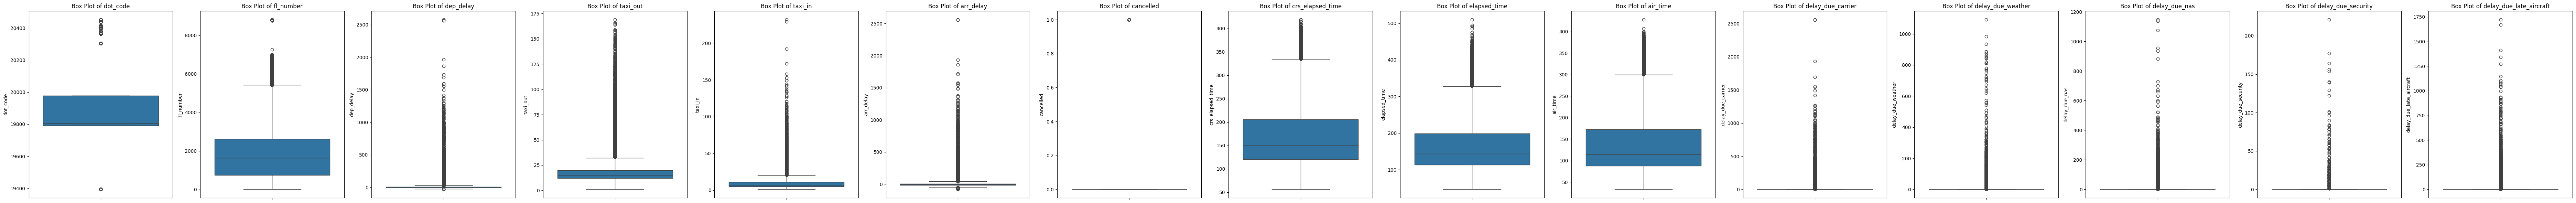

In [29]:
if columns_with_outliers:
    print(f"\nGenerating box plots for columns with outliers: {columns_with_outliers}")

    cols_sql = ", ".join(f'"{c}"' for c in columns_with_outliers)
    query = f"SELECT {cols_sql} FROM stg.flights_cleaned"

    with psycopg2.connect(**conn_args_from_env()) as conn:
        df_plot = pd.read_sql_query(query, conn)

    plt.figure(figsize=(5 * len(columns_with_outliers), 6))
    for i, col in enumerate(columns_with_outliers):
        plt.subplot(1, len(columns_with_outliers), i + 1)
        sns.boxplot(y=df_plot[col])
        plt.title(f'Box Plot of {col}')
    plt.tight_layout()
    plt.show()
else:
    print("\nNo columns found with outliers to visualize.")


## Cleaning Weather

In [30]:
query = "SELECT * FROM raw.weather_hourly_raw"
with psycopg2.connect(**conn_args_from_env()) as conn:
    weather_df = pd.read_sql_query(query, conn)


C:\Users\ryand\AppData\Local\Temp\ipykernel_5360\3819337540.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  weather_df = pd.read_sql_query(query, conn)


In [31]:
with psycopg2.connect(**conn_args_from_env()) as conn:
    with conn.cursor() as cur:
        cur.execute("CREATE SCHEMA IF NOT EXISTS stg;")
        cur.execute("DROP TABLE IF EXISTS stg.weather_cleaned;")
        cur.execute("CREATE TABLE stg.weather_cleaned AS SELECT * FROM raw.weather_hourly_raw;")
    conn.commit()


In [32]:
weather_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 408960 entries, 0 to 408959
Data columns (total 15 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   location_id          408960 non-null  float64       
 1   time                 408960 non-null  datetime64[ns]
 2   temperature_2m       408960 non-null  float64       
 3   precipitation        408960 non-null  float64       
 4   rain                 408960 non-null  float64       
 5   snowfall             408960 non-null  float64       
 6   weather_code         408960 non-null  float64       
 7   surface_pressure     408960 non-null  float64       
 8   cloud_cover          408960 non-null  float64       
 9   cloud_cover_low      408960 non-null  float64       
 10  wind_speed_10m       408960 non-null  float64       
 11  wind_speed_100m      408960 non-null  float64       
 12  wind_direction_10m   408960 non-null  float64       
 13  wind_direction

In [33]:
# Ambil list kolom dari stg.weather_cleaned
with psycopg2.connect(**conn_args_from_env()) as conn:
    cols_df = pd.read_sql_query(
        """
        SELECT column_name
        FROM information_schema.columns
        WHERE table_schema = 'stg'
          AND table_name = 'weather_cleaned'
        ORDER BY ordinal_position;
        """,
        conn
    )

cols = cols_df["column_name"].tolist()
cols_sql = ", ".join(f'"{c}"' for c in cols)

dup_count_query = f"""
SELECT SUM(cnt - 1) AS dup_count
FROM (
    SELECT {cols_sql}, COUNT(*) AS cnt
    FROM stg.weather_cleaned
    GROUP BY {cols_sql}
) t
WHERE cnt > 1
"""

dup_sample_query = f"""
SELECT {cols_sql}
FROM stg.weather_cleaned
GROUP BY {cols_sql}
HAVING COUNT(*) > 1
LIMIT 5
"""

with psycopg2.connect(**conn_args_from_env()) as conn:
    dup_count_df = pd.read_sql_query(dup_count_query, conn)
    duplicate_weather_rows = int(dup_count_df.at[0, "dup_count"] or 0)
    print(f"Duplicate rows (weather): {duplicate_weather_rows}")

    if duplicate_weather_rows > 0:
        weather_df = pd.read_sql_query(dup_sample_query, conn)
        weather_df.head()


C:\Users\ryand\AppData\Local\Temp\ipykernel_5360\1207744662.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  cols_df = pd.read_sql_query(
C:\Users\ryand\AppData\Local\Temp\ipykernel_5360\1207744662.py:36: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  dup_count_df = pd.read_sql_query(dup_count_query, conn)


Duplicate rows (weather): 0


# Standarisasi Data

## Flight Data

In [34]:
query = "SELECT * FROM stg.flights_cleaned"
with psycopg2.connect(**conn_args_from_env()) as conn:
    df = pd.read_sql_query(query, conn)


C:\Users\ryand\AppData\Local\Temp\ipykernel_5360\438111877.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


In [35]:
with psycopg2.connect(**conn_args_from_env()) as conn:
    with conn.cursor() as cur:
        cur.execute("DROP TABLE IF EXISTS stg.flights_standardized;")
        cur.execute("CREATE TABLE stg.flights_standardized AS SELECT * FROM stg.flights_cleaned;")
    conn.commit()


### Lowercase & Snakecase

In [38]:
with psycopg2.connect(**conn_args_from_env()) as conn:
    with conn.cursor() as cur:
        cur.execute(
            """
            SELECT column_name
            FROM information_schema.columns
            WHERE table_schema = 'stg'
              AND table_name = 'flights_standardized'
            ORDER BY ordinal_position;
            """
        )
        cols = [r[0] for r in cur.fetchall()]

        rename_pairs = [(c, c.lower()) for c in cols if c != c.lower()]

        for old, new in rename_pairs:
            cur.execute(f'ALTER TABLE stg.flights_standardized RENAME COLUMN "{old}" TO "{new}";')
    conn.commit()

with psycopg2.connect(**conn_args_from_env()) as conn:
    df = pd.read_sql_query("SELECT * FROM stg.flights_standardized", conn)

df.info()


C:\Users\ryand\AppData\Local\Temp\ipykernel_5360\2916397546.py:21: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query("SELECT * FROM stg.flights_standardized", conn)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 255119 entries, 0 to 255118
Data columns (total 31 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   fl_date                  255119 non-null  object 
 1   airline                  255119 non-null  object 
 2   airline_code             255119 non-null  object 
 3   dot_code                 255119 non-null  float64
 4   fl_number                255119 non-null  float64
 5   origin                   255119 non-null  object 
 6   origin_city              255119 non-null  object 
 7   dest                     255119 non-null  object 
 8   dest_city                255119 non-null  object 
 9   crs_dep_time             255119 non-null  float64
 10  dep_time                 248265 non-null  float64
 11  dep_delay                248265 non-null  float64
 12  taxi_out                 248124 non-null  float64
 13  wheels_off               248124 non-null  float64
 14  whee

### Encoding

#### Airline Column

In [39]:
with psycopg2.connect(**conn_args_from_env()) as conn:
    unique_count_df = pd.read_sql_query(
        "SELECT COUNT(DISTINCT airline) AS cnt FROM stg.flights_standardized",
        conn
    )
    unique_list_df = pd.read_sql_query(
        "SELECT DISTINCT airline FROM stg.flights_standardized ORDER BY airline",
        conn
    )

print(f"Total unique airlines: {int(unique_count_df.at[0, 'cnt'])}")
print("Unique airlines:")
print(unique_list_df["airline"].tolist())


C:\Users\ryand\AppData\Local\Temp\ipykernel_5360\2621050937.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  unique_count_df = pd.read_sql_query(
C:\Users\ryand\AppData\Local\Temp\ipykernel_5360\2621050937.py:6: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  unique_list_df = pd.read_sql_query(


Total unique airlines: 16
Unique airlines:
['Alaska Airlines Inc.', 'Allegiant Air', 'American Airlines Inc.', 'Delta Air Lines Inc.', 'Endeavor Air Inc.', 'Envoy Air', 'ExpressJet Airlines LLC d/b/a aha!', 'Frontier Airlines Inc.', 'JetBlue Airways', 'Mesa Airlines Inc.', 'PSA Airlines Inc.', 'Republic Airline', 'SkyWest Airlines Inc.', 'Southwest Airlines Co.', 'Spirit Air Lines', 'United Air Lines Inc.']


In [56]:
with psycopg2.connect(**conn_args_from_env()) as conn:
    mapping_df = pd.read_sql_query(
        """
        SELECT airline, MIN(airlines_encode) AS code
        FROM stg.flights_standardized
        GROUP BY airline
        ORDER BY airline
        """,
        conn
    )

print("Airline to Encoding Mapping:")
for _, row in mapping_df.iterrows():
    print(f"{row['airline']}: {int(row['code'])}")


Airline to Encoding Mapping:
Alaska Airlines Inc.: 0
Allegiant Air: 1
American Airlines Inc.: 2
Delta Air Lines Inc.: 3
Endeavor Air Inc.: 4
Envoy Air: 5
ExpressJet Airlines LLC d/b/a aha!: 6
Frontier Airlines Inc.: 7
JetBlue Airways: 8
Mesa Airlines Inc.: 9
PSA Airlines Inc.: 10
Republic Airline: 11
SkyWest Airlines Inc.: 12
Southwest Airlines Co.: 13
Spirit Air Lines: 14
United Air Lines Inc.: 15


C:\Users\ryand\AppData\Local\Temp\ipykernel_5360\1149065916.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  mapping_df = pd.read_sql_query(


#### Airline_Code Column

In [52]:
with psycopg2.connect(**conn_args_from_env()) as conn:
    unique_count_df = pd.read_sql_query(
        "SELECT COUNT(DISTINCT airline_code) AS cnt FROM stg.flights_standardized",
        conn
    )
    unique_list_df = pd.read_sql_query(
        "SELECT DISTINCT airline_code FROM stg.flights_standardized ORDER BY airline_code",
        conn
    )

print(f"Total unique airline_codes: {int(unique_count_df.at[0, 'cnt'])}")
print("Unique airline_codes:")
print(unique_list_df["airline_code"].tolist())


Total unique airline_codes: 16
Unique airline_codes:
['9E', 'AA', 'AS', 'B6', 'DL', 'EV', 'F9', 'G4', 'MQ', 'NK', 'OH', 'OO', 'UA', 'WN', 'YV', 'YX']


C:\Users\ryand\AppData\Local\Temp\ipykernel_5360\1440451617.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  unique_count_df = pd.read_sql_query(
C:\Users\ryand\AppData\Local\Temp\ipykernel_5360\1440451617.py:6: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  unique_list_df = pd.read_sql_query(


In [58]:
with psycopg2.connect(**conn_args_from_env()) as conn:
    with conn.cursor() as cur:
        cur.execute("""
            ALTER TABLE stg.flights_standardized
            ADD COLUMN IF NOT EXISTS airline_code_encode BIGINT;
        """)

        cur.execute("""
            WITH mapping AS (
                SELECT airline, DENSE_RANK() OVER (ORDER BY airline) - 1 AS code
                FROM (SELECT DISTINCT airline FROM stg.flights_standardized) t
            )
            UPDATE stg.flights_standardized s
            SET airline_code_encode = m.code
            FROM mapping m
            WHERE s.airline = m.airline;
        """)
    conn.commit()


In [63]:
with psycopg2.connect(**conn_args_from_env()) as conn:
    df = pd.read_sql_query(
        """
        SELECT airline_code, airline, airlines_encode, airline_code_encode
        FROM stg.flights_standardized
        ORDER BY airline, airline_code
        LIMIT 5
        """,
        conn
    )

print("First 5 rows of df with the new 'airline_code_encode' column:")
print(df)


First 5 rows of df with the new 'airline_code_encode' column:
  airline_code               airline  airlines_encode  airline_code_encode
0           AS  Alaska Airlines Inc.                0                    0
1           AS  Alaska Airlines Inc.                0                    0
2           AS  Alaska Airlines Inc.                0                    0
3           AS  Alaska Airlines Inc.                0                    0
4           AS  Alaska Airlines Inc.                0                    0


C:\Users\ryand\AppData\Local\Temp\ipykernel_5360\2409263907.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(


#### Origin Column

In [64]:
with psycopg2.connect(**conn_args_from_env()) as conn:
    unique_count_df = pd.read_sql_query(
        "SELECT COUNT(DISTINCT origin) AS cnt FROM stg.flights_standardized",
        conn
    )
    unique_list_df = pd.read_sql_query(
        "SELECT DISTINCT origin FROM stg.flights_standardized ORDER BY origin",
        conn
    )

print(f"Total unique Origin: {int(unique_count_df.at[0, 'cnt'])}")
print("Unique Origin:")
print(unique_list_df["origin"].tolist())


Total unique Origin: 15
Unique Origin:
['ATL', 'AZA', 'CLT', 'DCA', 'DEN', 'DFW', 'HOU', 'IAD', 'IAH', 'JFK', 'LAX', 'LGA', 'MDW', 'ORD', 'PHX']


C:\Users\ryand\AppData\Local\Temp\ipykernel_5360\1381341802.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  unique_count_df = pd.read_sql_query(
C:\Users\ryand\AppData\Local\Temp\ipykernel_5360\1381341802.py:6: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  unique_list_df = pd.read_sql_query(


In [65]:
with psycopg2.connect(**conn_args_from_env()) as conn:
    with conn.cursor() as cur:
        cur.execute("""
            ALTER TABLE stg.flights_standardized
            ADD COLUMN IF NOT EXISTS origin_encode BIGINT;
        """)

        cur.execute("""
            WITH mapping AS (
                SELECT origin, DENSE_RANK() OVER (ORDER BY origin) - 1 AS code
                FROM (SELECT DISTINCT origin FROM stg.flights_standardized) t
            )
            UPDATE stg.flights_standardized s
            SET origin_encode = m.code
            FROM mapping m
            WHERE s.origin = m.origin;
        """)
    conn.commit()


In [66]:
with psycopg2.connect(**conn_args_from_env()) as conn:
    df = pd.read_sql_query(
        """
        SELECT origin, origin_encode
        FROM stg.flights_standardized
        ORDER BY origin
        LIMIT 5
        """,
        conn
    )

print("First 5 rows of df with the new 'origin_encode' column:")
print(df)


First 5 rows of df with the new 'origin_encode' column:
  origin  origin_encode
0    ATL              0
1    ATL              0
2    ATL              0
3    ATL              0
4    ATL              0


C:\Users\ryand\AppData\Local\Temp\ipykernel_5360\1033205364.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(


In [68]:
with psycopg2.connect(**conn_args_from_env()) as conn:
    mapping_df = pd.read_sql_query(
        """
        SELECT origin, MIN(origin_encode) AS code
        FROM stg.flights_standardized
        GROUP BY origin
        ORDER BY origin
        """,
        conn
    )

print("Origin to Encoding Mapping:")
for _, row in mapping_df.iterrows():
    print(f"{row['origin']}: {int(row['code'])}")


Origin to Encoding Mapping:
ATL: 0
AZA: 1
CLT: 2
DCA: 3
DEN: 4
DFW: 5
HOU: 6
IAD: 7
IAH: 8
JFK: 9
LAX: 10
LGA: 11
MDW: 12
ORD: 13
PHX: 14


C:\Users\ryand\AppData\Local\Temp\ipykernel_5360\3462690951.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  mapping_df = pd.read_sql_query(


#### Origin_City Column

In [69]:
with psycopg2.connect(**conn_args_from_env()) as conn:
    unique_count_df = pd.read_sql_query(
        "SELECT COUNT(DISTINCT origin_city) AS cnt FROM stg.flights_standardized",
        conn
    )
    unique_list_df = pd.read_sql_query(
        "SELECT DISTINCT origin_city FROM stg.flights_standardized ORDER BY origin_city",
        conn
    )

print(f"Total unique Origin City: {int(unique_count_df.at[0, 'cnt'])}")
print("Unique Origin City:")
print(unique_list_df["origin_city"].tolist())


Total unique Origin City: 10
Unique Origin City:
['Atlanta, GA', 'Charlotte, NC', 'Chicago, IL', 'Dallas/Fort Worth, TX', 'Denver, CO', 'Houston, TX', 'Los Angeles, CA', 'New York, NY', 'Phoenix, AZ', 'Washington, DC']


C:\Users\ryand\AppData\Local\Temp\ipykernel_5360\374349431.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  unique_count_df = pd.read_sql_query(
C:\Users\ryand\AppData\Local\Temp\ipykernel_5360\374349431.py:6: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  unique_list_df = pd.read_sql_query(


In [70]:
with psycopg2.connect(**conn_args_from_env()) as conn:
    with conn.cursor() as cur:
        cur.execute("""
            ALTER TABLE stg.flights_standardized
            ADD COLUMN IF NOT EXISTS origin_cities_encode BIGINT;
        """)

        cur.execute("""
            WITH city_order AS (
                SELECT * FROM (VALUES
                    ('Chicago, IL', 1),
                    ('Atlanta, GA', 2),
                    ('Dallas/Fort Worth, TX', 3),
                    ('Denver, CO', 4),
                    ('New York, NY', 5),
                    ('Charlotte, NC', 6),
                    ('Houston, TX', 7),
                    ('Los Angeles, CA', 8),
                    ('Washington, DC', 9),
                    ('Phoenix, AZ', 10)
                ) AS v(city, ord)
            ),
            location_ids AS (
                SELECT location_id, ROW_NUMBER() OVER (ORDER BY location_id) AS rn
                FROM (
                    SELECT DISTINCT location_id
                    FROM stg.weather_cleaned
                    WHERE location_id IS NOT NULL
                ) t
            ),
            mapping AS (
                SELECT c.city, l.location_id
                FROM city_order c
                JOIN location_ids l ON l.rn = c.ord
            )
            UPDATE stg.flights_standardized s
            SET origin_cities_encode = m.location_id
            FROM mapping m
            WHERE s.origin_city = m.city;
        """)
    conn.commit()


In [71]:
with psycopg2.connect(**conn_args_from_env()) as conn:
    mapping_df = pd.read_sql_query(
        """
        WITH city_order AS (
            SELECT * FROM (VALUES
                ('Chicago, IL', 1),
                ('Atlanta, GA', 2),
                ('Dallas/Fort Worth, TX', 3),
                ('Denver, CO', 4),
                ('New York, NY', 5),
                ('Charlotte, NC', 6),
                ('Houston, TX', 7),
                ('Los Angeles, CA', 8),
                ('Washington, DC', 9),
                ('Phoenix, AZ', 10)
            ) AS v(city, ord)
        ),
        location_ids AS (
            SELECT location_id, ROW_NUMBER() OVER (ORDER BY location_id) AS rn
            FROM (
                SELECT DISTINCT location_id
                FROM stg.weather_cleaned
                WHERE location_id IS NOT NULL
            ) t
        )
        SELECT c.city, l.location_id
        FROM city_order c
        JOIN location_ids l ON l.rn = c.ord
        ORDER BY c.ord;
        """,
        conn
    )

print("City to location_id Mapping:")
for _, row in mapping_df.iterrows():
    print(f"{row['city']}: {int(row['location_id'])}")


City to location_id Mapping:
Chicago, IL: 0
Atlanta, GA: 1
Dallas/Fort Worth, TX: 2
Denver, CO: 3
New York, NY: 4
Charlotte, NC: 5
Houston, TX: 6
Los Angeles, CA: 7
Washington, DC: 8
Phoenix, AZ: 9


C:\Users\ryand\AppData\Local\Temp\ipykernel_5360\3665775552.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  mapping_df = pd.read_sql_query(


#### Dest Column

In [73]:
with psycopg2.connect(**conn_args_from_env()) as conn:
    unique_count_df = pd.read_sql_query(
        "SELECT COUNT(DISTINCT dest) AS cnt FROM stg.flights_standardized",
        conn
    )
    unique_list_df = pd.read_sql_query(
        "SELECT DISTINCT dest FROM stg.flights_standardized ORDER BY dest",
        conn
    )

print(f"Total unique Dest: {int(unique_count_df.at[0, 'cnt'])}")
print("Unique Dest:")
print(unique_list_df["dest"].tolist())


Total unique Dest: 15
Unique Dest:
['ATL', 'AZA', 'CLT', 'DCA', 'DEN', 'DFW', 'HOU', 'IAD', 'IAH', 'JFK', 'LAX', 'LGA', 'MDW', 'ORD', 'PHX']


C:\Users\ryand\AppData\Local\Temp\ipykernel_5360\3900930157.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  unique_count_df = pd.read_sql_query(
C:\Users\ryand\AppData\Local\Temp\ipykernel_5360\3900930157.py:6: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  unique_list_df = pd.read_sql_query(


In [74]:
with psycopg2.connect(**conn_args_from_env()) as conn:
    with conn.cursor() as cur:
        cur.execute("""
            ALTER TABLE stg.flights_standardized
            ADD COLUMN IF NOT EXISTS dest_encode BIGINT;
        """)

        cur.execute("""
            WITH mapping AS (
                SELECT dest, DENSE_RANK() OVER (ORDER BY dest) - 1 AS code
                FROM (SELECT DISTINCT dest FROM stg.flights_standardized) t
            )
            UPDATE stg.flights_standardized s
            SET dest_encode = m.code
            FROM mapping m
            WHERE s.dest = m.dest;
        """)
    conn.commit()


In [41]:
print("Dest to Encoding Mapping:")
for i, dest_name in enumerate(label_encoder.classes_):
    print(f"{dest_name}: {i}")

Dest to Encoding Mapping:
ATL: 0
AZA: 1
CLT: 2
DCA: 3
DEN: 4
DFW: 5
HOU: 6
IAD: 7
IAH: 8
JFK: 9
LAX: 10
LGA: 11
MDW: 12
ORD: 13
PHX: 14


In [75]:
with psycopg2.connect(**conn_args_from_env()) as conn:
    df = pd.read_sql_query(
        """
        SELECT dest, dest_encode
        FROM stg.flights_standardized
        ORDER BY dest
        LIMIT 5
        """,
        conn
    )

print("First 5 rows of df with the new 'dest_encode' column:")
print(df)


First 5 rows of df with the new 'dest_encode' column:
  dest  dest_encode
0  ATL            0
1  ATL            0
2  ATL            0
3  ATL            0
4  ATL            0


C:\Users\ryand\AppData\Local\Temp\ipykernel_5360\3993109737.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(


In [76]:
with psycopg2.connect(**conn_args_from_env()) as conn:
    mapping_df = pd.read_sql_query(
        """
        SELECT dest, MIN(dest_encode) AS code
        FROM stg.flights_standardized
        GROUP BY dest
        ORDER BY dest
        """,
        conn
    )

print("Dest to Encoding Mapping:")
for _, row in mapping_df.iterrows():
    print(f"{row['dest']}: {int(row['code'])}")


Dest to Encoding Mapping:
ATL: 0
AZA: 1
CLT: 2
DCA: 3
DEN: 4
DFW: 5
HOU: 6
IAD: 7
IAH: 8
JFK: 9
LAX: 10
LGA: 11
MDW: 12
ORD: 13
PHX: 14


C:\Users\ryand\AppData\Local\Temp\ipykernel_5360\1167110163.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  mapping_df = pd.read_sql_query(


#### Dest_City Column

In [77]:
with psycopg2.connect(**conn_args_from_env()) as conn:
    unique_count_df = pd.read_sql_query(
        "SELECT COUNT(DISTINCT dest_city) AS cnt FROM stg.flights_standardized",
        conn
    )
    unique_list_df = pd.read_sql_query(
        "SELECT DISTINCT dest_city FROM stg.flights_standardized ORDER BY dest_city",
        conn
    )

print(f"Total unique Dest_City: {int(unique_count_df.at[0, 'cnt'])}")
print("Unique Dest_City:")
print(unique_list_df["dest_city"].tolist())


Total unique Dest_City: 10
Unique Dest_City:
['Atlanta, GA', 'Charlotte, NC', 'Chicago, IL', 'Dallas/Fort Worth, TX', 'Denver, CO', 'Houston, TX', 'Los Angeles, CA', 'New York, NY', 'Phoenix, AZ', 'Washington, DC']


C:\Users\ryand\AppData\Local\Temp\ipykernel_5360\2834840996.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  unique_count_df = pd.read_sql_query(
C:\Users\ryand\AppData\Local\Temp\ipykernel_5360\2834840996.py:6: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  unique_list_df = pd.read_sql_query(


In [78]:
with psycopg2.connect(**conn_args_from_env()) as conn:
    with conn.cursor() as cur:
        cur.execute("""
            ALTER TABLE stg.flights_standardized
            ADD COLUMN IF NOT EXISTS dest_cities_encode BIGINT;
        """)

        cur.execute("""
            WITH city_order AS (
                SELECT * FROM (VALUES
                    ('Chicago, IL', 1),
                    ('Atlanta, GA', 2),
                    ('Dallas/Fort Worth, TX', 3),
                    ('Denver, CO', 4),
                    ('New York, NY', 5),
                    ('Charlotte, NC', 6),
                    ('Houston, TX', 7),
                    ('Los Angeles, CA', 8),
                    ('Washington, DC', 9),
                    ('Phoenix, AZ', 10)
                ) AS v(city, ord)
            ),
            location_ids AS (
                SELECT location_id, ROW_NUMBER() OVER (ORDER BY location_id) AS rn
                FROM (
                    SELECT DISTINCT location_id
                    FROM stg.weather_cleaned
                    WHERE location_id IS NOT NULL
                ) t
            ),
            mapping AS (
                SELECT c.city, l.location_id
                FROM city_order c
                JOIN location_ids l ON l.rn = c.ord
            )
            UPDATE stg.flights_standardized s
            SET dest_cities_encode = m.location_id
            FROM mapping m
            WHERE s.dest_city = m.city;
        """)
    conn.commit()


In [79]:
with psycopg2.connect(**conn_args_from_env()) as conn:
    mapping_df = pd.read_sql_query(
        """
        WITH city_order AS (
            SELECT * FROM (VALUES
                ('Chicago, IL', 1),
                ('Atlanta, GA', 2),
                ('Dallas/Fort Worth, TX', 3),
                ('Denver, CO', 4),
                ('New York, NY', 5),
                ('Charlotte, NC', 6),
                ('Houston, TX', 7),
                ('Los Angeles, CA', 8),
                ('Washington, DC', 9),
                ('Phoenix, AZ', 10)
            ) AS v(city, ord)
        ),
        location_ids AS (
            SELECT location_id, ROW_NUMBER() OVER (ORDER BY location_id) AS rn
            FROM (
                SELECT DISTINCT location_id
                FROM stg.weather_cleaned
                WHERE location_id IS NOT NULL
            ) t
        )
        SELECT c.city, l.location_id
        FROM city_order c
        JOIN location_ids l ON l.rn = c.ord
        ORDER BY c.ord;
        """,
        conn
    )

print("City to location_id Mapping:")
for _, row in mapping_df.iterrows():
    print(f"{row['city']}: {int(row['location_id'])}")


City to location_id Mapping:
Chicago, IL: 0
Atlanta, GA: 1
Dallas/Fort Worth, TX: 2
Denver, CO: 3
New York, NY: 4
Charlotte, NC: 5
Houston, TX: 6
Los Angeles, CA: 7
Washington, DC: 8
Phoenix, AZ: 9


C:\Users\ryand\AppData\Local\Temp\ipykernel_5360\3665775552.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  mapping_df = pd.read_sql_query(


#### Standardized Date

In [80]:
# Pada column ini kita hanya menghapus tanda "-" di format tanggalnya lalu merubah tipenya menjadi int.
# Format tanggal = yyyy/mm/dd
# Tipe data kolom fl_date berisi string + non string sehingga harus diubah terlebih dahulu

with psycopg2.connect(**conn_args_from_env()) as conn:
    with conn.cursor() as cur:
        cur.execute("""
            ALTER TABLE stg.flights_standardized
            ALTER COLUMN fl_date
            TYPE BIGINT
            USING (
                CASE
                    WHEN fl_date IS NULL THEN NULL
                    ELSE to_char(fl_date::date, 'YYYYMMDD')::bigint
                END
            );
        """)
    conn.commit()

In [81]:
with psycopg2.connect(**conn_args_from_env()) as conn:
    df = pd.read_sql_query(
        "SELECT fl_date FROM stg.flights_standardized LIMIT 5",
        conn
    )

print("Data type of 'fl_date' column after transformation:")
print(df["fl_date"].dtype)
print("First 5 rows of 'fl_date' after transformation:")
print(df["fl_date"].head())


Data type of 'fl_date' column after transformation:
int64
First 5 rows of 'fl_date' after transformation:
0    20190704
1    20190816
2    20191009
3    20190822
4    20200521
Name: fl_date, dtype: int64


C:\Users\ryand\AppData\Local\Temp\ipykernel_5360\1443365098.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(


### Consistency Data Types for Every Column

Pada kolom yang memiliki informasi waktu (CRS_DEP_TIME, DEP_TIME, CRS_ARR_TIME, ARR_TIME, dsb) tipe datanya ada yang masih int dan float. Karena nilai datanya pada satuan menit (misal CRS_DEP_TIME = 1151 (11.51) dan DEP_TIME = 15.0 (15 menit) maka kami putuskan untuk mengubahnya menjadi int. Hal yang sama juga diterapkan untuk kolom dengan nilai biner (CANCELLED dan DIVERTED).

Pada penerbangan yang dicancel, nilai kolom DEP_TIME, ARR_TIME, dsb masih berupa NaN. Karena tipe data int tidak bisa menghandle missing value, maka kami lakukan imputasi tambahan untuk missing value tersebut.

In [82]:
time_related_nullable_columns = [
    'dep_time', 'dep_delay', 'taxi_out', 'wheels_off', 'wheels_on',
    'taxi_in', 'arr_time', 'arr_delay', 'elapsed_time', 'air_time'
]

set_clause = ", ".join([f'"{c}" = COALESCE("{c}", 0)' for c in time_related_nullable_columns])

with psycopg2.connect(**conn_args_from_env()) as conn:
    with conn.cursor() as cur:
        cur.execute(f"""
            UPDATE stg.flights_standardized
            SET {set_clause}
            WHERE cancelled = 1;
        """)
    conn.commit()

# cek missing values (opsional)
with psycopg2.connect(**conn_args_from_env()) as conn:
    cols_df = pd.read_sql_query(
        """
        SELECT column_name
        FROM information_schema.columns
        WHERE table_schema = 'stg'
          AND table_name = 'flights_standardized'
        ORDER BY ordinal_position;
        """,
        conn
    )
    cols = cols_df["column_name"].tolist()

missing_exprs = []
for col in cols:
    col_escaped = col.replace('"', '""')
    missing_exprs.append(
        f'SUM(CASE WHEN "{col_escaped}" IS NULL THEN 1 ELSE 0 END) AS "{col_escaped}"'
    )

query = "SELECT " + ", ".join(missing_exprs) + " FROM stg.flights_standardized"
with psycopg2.connect(**conn_args_from_env()) as conn:
    missing_counts = pd.read_sql_query(query, conn)

print("Missing values in time-related columns after handling cancelled flights:")
print(missing_counts.T.loc[time_related_nullable_columns])


C:\Users\ryand\AppData\Local\Temp\ipykernel_5360\814134756.py:19: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  cols_df = pd.read_sql_query(
C:\Users\ryand\AppData\Local\Temp\ipykernel_5360\814134756.py:40: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  missing_counts = pd.read_sql_query(query, conn)


Missing values in time-related columns after handling cancelled flights:
              0
dep_time      0
dep_delay     0
taxi_out      0
wheels_off    0
wheels_on     0
taxi_in       0
arr_time      0
arr_delay     0
elapsed_time  0
air_time      0


In [83]:
float_cols_to_int = [
    'dep_time', 'dep_delay', 'taxi_out', 'wheels_off', 'wheels_on',
    'taxi_in', 'arr_time', 'arr_delay', 'cancelled', 'diverted',
    'crs_elapsed_time', 'elapsed_time', 'air_time', 'distance',
    'delay_due_carrier', 'delay_due_weather', 'delay_due_nas',
    'delay_due_security', 'delay_due_late_aircraft'
]

with psycopg2.connect(**conn_args_from_env()) as conn:
    with conn.cursor() as cur:
        for col in float_cols_to_int:
            cur.execute(f"""
                ALTER TABLE stg.flights_standardized
                ALTER COLUMN "{col}" TYPE BIGINT
                USING "{col}"::bigint;
            """)
    conn.commit()

with psycopg2.connect(**conn_args_from_env()) as conn:
    df = pd.read_sql_query("SELECT * FROM stg.flights_standardized LIMIT 5", conn)

print("Data types after converting specified float columns to int:")
df.info()


Data types after converting specified float columns to int:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 37 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   fl_date                  5 non-null      int64  
 1   airline                  5 non-null      object 
 2   airline_code             5 non-null      object 
 3   dot_code                 5 non-null      float64
 4   fl_number                5 non-null      float64
 5   origin                   5 non-null      object 
 6   origin_city              5 non-null      object 
 7   dest                     5 non-null      object 
 8   dest_city                5 non-null      object 
 9   crs_dep_time             5 non-null      float64
 10  dep_time                 5 non-null      int64  
 11  dep_delay                5 non-null      int64  
 12  taxi_out                 5 non-null      int64  
 13  wheels_off              

C:\Users\ryand\AppData\Local\Temp\ipykernel_5360\1215497238.py:20: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query("SELECT * FROM stg.flights_standardized LIMIT 5", conn)


## Weather Data

In [85]:
query = "SELECT * FROM stg.weather_cleaned"
with psycopg2.connect(**conn_args_from_env()) as conn:
    weather_df = pd.read_sql_query(query, conn)


C:\Users\ryand\AppData\Local\Temp\ipykernel_5360\980955280.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  weather_df = pd.read_sql_query(query, conn)


In [86]:
with psycopg2.connect(**conn_args_from_env()) as conn:
    with conn.cursor() as cur:
        cur.execute("DROP TABLE IF EXISTS stg.weather_standardized;")
        cur.execute("CREATE TABLE stg.weather_standardized AS SELECT * FROM stg.weather_cleaned;")
    conn.commit()


In [87]:
weather_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 408960 entries, 0 to 408959
Data columns (total 15 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   location_id          408960 non-null  float64       
 1   time                 408960 non-null  datetime64[ns]
 2   temperature_2m       408960 non-null  float64       
 3   precipitation        408960 non-null  float64       
 4   rain                 408960 non-null  float64       
 5   snowfall             408960 non-null  float64       
 6   weather_code         408960 non-null  float64       
 7   surface_pressure     408960 non-null  float64       
 8   cloud_cover          408960 non-null  float64       
 9   cloud_cover_low      408960 non-null  float64       
 10  wind_speed_10m       408960 non-null  float64       
 11  wind_speed_100m      408960 non-null  float64       
 12  wind_direction_10m   408960 non-null  float64       
 13  wind_direction

berdasarkan informasi diatas hanya terdapat 1 tipe data object saja yakni pada column time sehingga hanya tipe data ini saja yang kita lakukan encoding

In [88]:
weather_df.head()

,location_id,time,temperature_2m,precipitation,rain,snowfall,weather_code,surface_pressure,cloud_cover,cloud_cover_low,wind_speed_10m,wind_speed_100m,wind_direction_10m,wind_direction_100m,wind_gusts_10m
0,0.0,2019-01-01 00:00:00,1.2,0.0,0.0,0.0,3.0,992.4,100.0,100.0,17.7,29.1,321.0,326.0,30.2
1,0.0,2019-01-01 01:00:00,1.1,0.0,0.0,0.0,3.0,993.9,100.0,100.0,16.6,26.7,321.0,328.0,25.9
2,0.0,2019-01-01 02:00:00,0.9,0.0,0.0,0.0,3.0,995.5,100.0,100.0,19.2,29.2,332.0,338.0,27.4
3,0.0,2019-01-01 03:00:00,0.4,0.0,0.0,0.0,3.0,997.0,100.0,100.0,20.2,29.7,338.0,341.0,30.2
4,0.0,2019-01-01 04:00:00,-0.2,0.0,0.0,0.0,3.0,998.1,100.0,100.0,21.0,30.0,344.0,346.0,30.6


Jika kita lihat bentuknya kami tidak mungkin langsung merubah menjadi angka random. kami berencana untuk mempertahankan bentuk aslinya sehingga kami akan menghapus tanda "-" dan T pada isi column tersebut. Untuk membuatnya lebih mudah dibaca kami akan menambahkan 2 column baru yakni date dan time. column ini dipisah agar tidak memusingkan jika dibaca dalam satu column.

Format:
- date = yyyy/mm/dd
- time = xx:xx -> if 0 means 00:00, 100 means 01:00, etc.

In [90]:
with psycopg2.connect(**conn_args_from_env()) as conn:
    with conn.cursor() as cur:
        cur.execute("""
            ALTER TABLE stg.weather_standardized
            ADD COLUMN IF NOT EXISTS "date" BIGINT;
        """)
        cur.execute("""
            ALTER TABLE stg.weather_standardized
            ADD COLUMN IF NOT EXISTS "time_hour_minute" BIGINT;
        """)
        cur.execute("""
            UPDATE stg.weather_standardized
            SET
                "date" = to_char("time", 'YYYYMMDD')::bigint,
                "time_hour_minute" = to_char("time", 'HH24MI')::bigint
            WHERE "time" IS NOT NULL;
        """)
    conn.commit()

In [91]:
with psycopg2.connect(**conn_args_from_env()) as conn:
    weather_df = pd.read_sql_query(
        'SELECT "time", "date", "time_hour_minute" FROM stg.weather_standardized LIMIT 5',
        conn
    )
print(weather_df)


                 time      date  time_hour_minute
0 2022-12-27 04:00:00  20221227               400
1 2019-01-01 00:00:00  20190101                 0
2 2019-01-01 01:00:00  20190101               100
3 2019-01-01 02:00:00  20190101               200
4 2019-01-01 03:00:00  20190101               300


C:\Users\ryand\AppData\Local\Temp\ipykernel_5360\866477823.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  weather_df = pd.read_sql_query(


# Data Enrichment dan Feature Engineering

## Join Flight DF & Weather DF

sebelum dilakukan penggabungan 3 df ada yang perlu dijadikan patokkan. dalam kasus ini kami memutuskan akan menggunakan column 5 column pada dataframe flight dan 3 column pada dataframe weather. flight akan memiliki data weather sebelum berangkat dan pada saat jadwal sampai. itulah mengapa kita perlu 5 column pada dataframe flight. berikut merupakan column yang digunakan.

Flight:
- fl_date
- origin_city_encoded
- dest_city_encoded
- crs_dep_time_rounded
- crs_arr_time_rounded

Weather:
- date
- time_hour_minute
- location_id

sebelum kita menggabungkan kolom tersebut, kita perlu menseragamkan format waktunya terutama dibagian jamnya karena masih terdapat menit. ini akan kita bulatkan kebawah untuk menyesuaikan data waktu yang ada pada dataframe di weather.

In [95]:
with psycopg2.connect(**conn_args_from_env()) as conn:
    with conn.cursor() as cur:
        cur.execute("""
            ALTER TABLE stg.flights_standardized
            ADD COLUMN IF NOT EXISTS crs_dep_time_rounded BIGINT;
        """)
        cur.execute("""
            ALTER TABLE stg.flights_standardized
            ADD COLUMN IF NOT EXISTS crs_arr_time_rounded BIGINT;
        """)

        cur.execute("""
            UPDATE stg.flights_standardized
            SET
                crs_dep_time_rounded = CASE
                    WHEN crs_dep_time IS NULL THEN NULL
                    ELSE (crs_dep_time::bigint / 100) * 100
                END,
                crs_arr_time_rounded = CASE
                    WHEN crs_arr_time IS NULL THEN NULL
                    ELSE (crs_arr_time::bigint / 100) * 100
                END;
        """)
    conn.commit()

with psycopg2.connect(**conn_args_from_env()) as conn:
    df = pd.read_sql_query(
        """
        SELECT crs_dep_time, crs_dep_time_rounded, crs_arr_time, crs_arr_time_rounded
        FROM stg.flights_standardized
        LIMIT 5
        """,
        conn
    )

print(df)


   crs_dep_time  crs_dep_time_rounded  crs_arr_time  crs_arr_time_rounded
0        1618.0                  1600        1737.0                  1700
1        2040.0                  2000        2257.0                  2200
2        1046.0                  1000        1346.0                  1300
3        1821.0                  1800        2000.0                  2000
4        1040.0                  1000        1344.0                  1300


C:\Users\ryand\AppData\Local\Temp\ipykernel_5360\3017946863.py:27: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(


sekarang masuk kedalam proses mergingnya

In [96]:
with psycopg2.connect(**conn_args_from_env()) as conn:
    cols_df = pd.read_sql_query(
        """
        SELECT column_name
        FROM information_schema.columns
        WHERE table_schema = 'stg'
          AND table_name = 'weather_standardized'
        ORDER BY ordinal_position;
        """,
        conn
    )

weather_cols = [
    c for c in cols_df["column_name"].tolist()
    if c not in ("location_id", "date", "time_hour_minute")
]

origin_cols_sql = ", ".join([f'w_origin."{c}" AS "origin_{c}"' for c in weather_cols])
dest_cols_sql = ", ".join([f'w_dest."{c}" AS "dest_{c}"' for c in weather_cols])

join_sql = f"""
DROP TABLE IF EXISTS stg.flights_weather_merged;

CREATE TABLE stg.flights_weather_merged AS
SELECT
    f.*,
    {origin_cols_sql},
    {dest_cols_sql}
FROM stg.flights_standardized f
LEFT JOIN stg.weather_standardized w_origin
  ON f.fl_date = w_origin.date
 AND f.origin_cities_encode::bigint = w_origin.location_id::bigint
 AND f.crs_dep_time_rounded = w_origin.time_hour_minute
LEFT JOIN stg.weather_standardized w_dest
  ON f.fl_date = w_dest.date
 AND f.dest_cities_encode::bigint = w_dest.location_id::bigint
 AND f.crs_arr_time_rounded = w_dest.time_hour_minute;
"""

with psycopg2.connect(**conn_args_from_env()) as conn:
    with conn.cursor() as cur:
        cur.execute(join_sql)
    conn.commit()


C:\Users\ryand\AppData\Local\Temp\ipykernel_5360\3446124647.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  cols_df = pd.read_sql_query(


In [100]:
with psycopg2.connect(**conn_args_from_env()) as conn:
    merged_df = pd.read_sql_query(
        """
        SELECT * FROM stg.flights_weather_merged
        """,
        conn
    )

merged_df.info()


C:\Users\ryand\AppData\Local\Temp\ipykernel_5360\3099782299.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  merged_df = pd.read_sql_query(


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 255119 entries, 0 to 255118
Data columns (total 67 columns):
 #   Column                      Non-Null Count   Dtype         
---  ------                      --------------   -----         
 0   fl_date                     255119 non-null  int64         
 1   airline                     255119 non-null  object        
 2   airline_code                255119 non-null  object        
 3   dot_code                    255119 non-null  float64       
 4   fl_number                   255119 non-null  float64       
 5   origin                      255119 non-null  object        
 6   origin_city                 255119 non-null  object        
 7   dest                        255119 non-null  object        
 8   dest_city                   255119 non-null  object        
 9   crs_dep_time                255119 non-null  float64       
 10  dep_time                    255119 non-null  int64         
 11  dep_delay                   255119 non-

## Feature Engineering

### temp_2m_diff

kolom ini dibuat dengan tujuan untuk melihat selisih temperatur atau suhu pada lokasi awal dengan destinasi.

Pengaruh perbedaan suhu dalam penerbangan pesawat.
- Suhu mempengaruhi kepadatan udara:
  - Udara panas -> lebih ringan -> lift berkurang
  - Udara dingin -> lebih padat -> lift bertambah
- Jika selisih suhu besar:
  - Pesawat harus menyesuaikan performa mesin
  - Perubahan konfigurasi approach
  - Potensi unstable approach
- Dampak Operasional:
  - Runway performance calculation berubah
  - Bisa terjadi go-around
  - Arrival delay meningkat



In [101]:
with psycopg2.connect(**conn_args_from_env()) as conn:
    with conn.cursor() as cur:
        cur.execute("""
            ALTER TABLE stg.flights_weather_merged
            ADD COLUMN IF NOT EXISTS temp_2m_diff DOUBLE PRECISION;
        """)

        cur.execute("""
            UPDATE stg.flights_weather_merged
            SET temp_2m_diff = dest_temperature_2m - origin_temperature_2m
            WHERE dest_temperature_2m IS NOT NULL
              AND origin_temperature_2m IS NOT NULL;
        """)
    conn.commit()


In [102]:
with psycopg2.connect(**conn_args_from_env()) as conn:
    final_merged_df = pd.read_sql_query(
        """
        SELECT origin_temperature_2m, dest_temperature_2m, temp_2m_diff
        FROM stg.flights_weather_merged
        LIMIT 5
        """,
        conn
    )

print("First 5 rows with new 'temp_2m_diff' column:")
print(final_merged_df)


First 5 rows with new 'temp_2m_diff' column:
   origin_temperature_2m  dest_temperature_2m  temp_2m_diff
0                    2.7                 12.8          10.1
1                    8.2                  3.2          -5.0
2                    7.6                 17.0           9.4
3                   -7.8                -13.1          -5.3
4                    3.0                  0.2          -2.8


C:\Users\ryand\AppData\Local\Temp\ipykernel_5360\2832124959.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  final_merged_df = pd.read_sql_query(


### surface_pressure_diff

Kolom ini dibuat dengan tujuan untuk melihat selisih surface pressure pada lokasi awal dengan destinasi

Pengaruh perbedaan tekanan udara di daratan dalam penerbangan pesawat.
- Tekanan udara rendah biasanya terkait:
  - sistem badai
  - Hujan, awan tebal, dan angin kuat
- Selisih tekanan besar -> indikasi front cuaca aktif.
- Dampak Operasional:
  - Holding pattern
  - Runway configuration berubah
  - ATC spacing diperlebar
  - Arrival delay

In [103]:
with psycopg2.connect(**conn_args_from_env()) as conn:
    with conn.cursor() as cur:
        cur.execute("""
            ALTER TABLE stg.flights_weather_merged
            ADD COLUMN IF NOT EXISTS surface_pressure_diff DOUBLE PRECISION;
        """)

        cur.execute("""
            UPDATE stg.flights_weather_merged
            SET surface_pressure_diff = dest_surface_pressure - origin_surface_pressure
            WHERE dest_surface_pressure IS NOT NULL
              AND origin_surface_pressure IS NOT NULL;
        """)
    conn.commit()


In [104]:
with psycopg2.connect(**conn_args_from_env()) as conn:
    final_merged_df = pd.read_sql_query(
        """
        SELECT origin_surface_pressure, dest_surface_pressure, surface_pressure_diff
        FROM stg.flights_weather_merged
        LIMIT 5
        """,
        conn
    )

print("First 5 rows with new 'surface_pressure_diff' column:")
print(final_merged_df)


First 5 rows with new 'surface_pressure_diff' column:
   origin_surface_pressure  dest_surface_pressure  surface_pressure_diff
0                    991.7                 1007.1                   15.4
1                    995.2                 1018.2                   23.0
2                    980.7                 1016.6                   35.9
3                    835.3                 1018.6                  183.3
4                   1003.8                  992.9                  -10.9


C:\Users\ryand\AppData\Local\Temp\ipykernel_5360\2531685975.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  final_merged_df = pd.read_sql_query(


### wind_speed_10m_km/h_diff

kolom ini dibuat dengan tujuan untuk melihat selisih wind speed di 10m pada lokasi awal dengan destinasi.

Pengaruh perbedaan kecepatan udara di daratan dalam penerbangan pesawat.
- Angin permukaan berpengaruh langsung pada:
  - Taxi
  - Takeoff
  - Landing
- Jika angin di destinasi jauh lebih kuat:
  - Pesawat lebih sulit untuk mendarat
  - Runway yang bisa dipakai terbatas
  - Potensi go-around
- Dampak Operasional:
  - Arrival rate bandara menurun
  - Antrean landing
  - Delay meningkat

In [106]:
with psycopg2.connect(**conn_args_from_env()) as conn:
    with conn.cursor() as cur:
        cur.execute("""
            ALTER TABLE stg.flights_weather_merged
            ADD COLUMN IF NOT EXISTS wind_speed_10m_diff DOUBLE PRECISION;
        """)

        cur.execute("""
            UPDATE stg.flights_weather_merged
            SET wind_speed_10m_diff = dest_wind_speed_10m - origin_wind_speed_10m
            WHERE dest_wind_speed_10m IS NOT NULL
              AND origin_wind_speed_10m IS NOT NULL;
        """)
    conn.commit()


In [107]:
with psycopg2.connect(**conn_args_from_env()) as conn:
    final_merged_df = pd.read_sql_query(
        """
        SELECT origin_wind_speed_10m, dest_wind_speed_10m, wind_speed_10m_diff
        FROM stg.flights_weather_merged
        LIMIT 5
        """,
        conn
    )

print("First 5 rows with new 'wind_speed_10m_diff' column:")
print(final_merged_df)


First 5 rows with new 'wind_speed_10m_diff' column:
   origin_wind_speed_10m  dest_wind_speed_10m  wind_speed_10m_diff
0                    8.3                 27.8                 19.5
1                   21.8                 22.7                  0.9
2                    7.1                 11.5                  4.4
3                   15.6                  8.0                 -7.6
4                   10.0                  8.0                 -2.0


C:\Users\ryand\AppData\Local\Temp\ipykernel_5360\1826992865.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  final_merged_df = pd.read_sql_query(


### wind_speed_100m_km/h_diff

kolom ini dibuat dengan tujuan untuk melihat selisih wind speed di 100m pada lokasi awal dengan destinasi

Pengaruh perbedaan kecepatan udara di atas dalam penerbangan pesawat.
- angin di 100m memengaruhi:
  - Stabilitas approach
  - Vertical wind shear
  - Turbulensi
- Selisih besar -> udara tidak stabil
- Dampak Operasional
  - Unstable approach
  - Holding / go-around
  - spacing antar pesawat diperbesar

In [108]:
with psycopg2.connect(**conn_args_from_env()) as conn:
    with conn.cursor() as cur:
        cur.execute("""
            ALTER TABLE stg.flights_weather_merged
            ADD COLUMN IF NOT EXISTS wind_speed_100m_diff DOUBLE PRECISION;
        """)

        cur.execute("""
            UPDATE stg.flights_weather_merged
            SET wind_speed_100m_diff = dest_wind_speed_100m - origin_wind_speed_100m
            WHERE dest_wind_speed_100m IS NOT NULL
              AND origin_wind_speed_100m IS NOT NULL;
        """)
    conn.commit()


In [109]:
with psycopg2.connect(**conn_args_from_env()) as conn:
    final_merged_df = pd.read_sql_query(
        """
        SELECT origin_wind_speed_100m, dest_wind_speed_100m, wind_speed_100m_diff
        FROM stg.flights_weather_merged
        LIMIT 5
        """,
        conn
    )

print("First 5 rows with new 'wind_speed_100m_diff' column:")
print(final_merged_df)


First 5 rows with new 'wind_speed_100m_diff' column:
   origin_wind_speed_100m  dest_wind_speed_100m  wind_speed_100m_diff
0                    11.6                  14.0                   2.4
1                     9.5                  14.7                   5.2
2                    45.6                  19.5                 -26.1
3                    10.0                  18.4                   8.4
4                    13.7                  28.1                  14.4


C:\Users\ryand\AppData\Local\Temp\ipykernel_5360\2686287365.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  final_merged_df = pd.read_sql_query(


### dest_cloud_cover_diff

kolom ini dibuat dengan tujuan untuk melihat selisih dest_cloud_cover pada percent dengan low_percent

Pengaruh selisih intensitas awan pada penerbangan pesawat:
- ini indikator ceiling (ketinggian awan rendah).
  - Low cloud tinggi -> visibilitas rendah
  - Instrument approach wajib
  - kapasitas bandara menurun
- Dampak Operasional
  - Arrival delay
  - Go-around
  - Diversion pada kasus ekstrem

In [110]:
with psycopg2.connect(**conn_args_from_env()) as conn:
    with conn.cursor() as cur:
        cur.execute("""
            ALTER TABLE stg.flights_weather_merged
            ADD COLUMN IF NOT EXISTS dest_cloud_cover_diff DOUBLE PRECISION;
        """)

        cur.execute("""
            UPDATE stg.flights_weather_merged
            SET dest_cloud_cover_diff = dest_cloud_cover - dest_cloud_cover_low
            WHERE dest_cloud_cover IS NOT NULL
              AND dest_cloud_cover_low IS NOT NULL;
        """)
    conn.commit()


In [111]:
with psycopg2.connect(**conn_args_from_env()) as conn:
    final_merged_df = pd.read_sql_query(
        """
        SELECT dest_cloud_cover, dest_cloud_cover_low, dest_cloud_cover_diff
        FROM stg.flights_weather_merged
        LIMIT 5
        """,
        conn
    )

print("First 5 rows with new 'dest_cloud_cover_diff' column:")
print(final_merged_df)


First 5 rows with new 'dest_cloud_cover_diff' column:
   dest_cloud_cover  dest_cloud_cover_low  dest_cloud_cover_diff
0              54.0                  10.0                   44.0
1              64.0                   1.0                   63.0
2               8.0                   0.0                    8.0
3               2.0                   0.0                    2.0
4              78.0                  73.0                    5.0


C:\Users\ryand\AppData\Local\Temp\ipykernel_5360\107975070.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  final_merged_df = pd.read_sql_query(


### Tabel Threshold Risiko Delay: Selisih Cuaca (Origin vs Destination)


| Fitur Selisih (Delta) | Satuan | **Risiko Ringan** (Waspada) | **Risiko Berat** (Bahaya) | Penjelasan Ilmiah & Dampak Operasional |
| :--- | :---: | :---: | :---: | :--- |
| **`temp_diff`** | °C | **15 - 25** | **> 25** | **Frontal Boundary:**<br>Selisih suhu ekstrem menandakan pesawat melintasi batas massa udara (Front).<br>Risiko guncangan (*Clear Air Turbulence*) tinggi di perbatasan ini. |
| **`pressure_diff`** | hPa | **10 - 20** | **> 20** | **Pressure Gradient:**<br>Selisih tekanan adalah pemicu angin.<br>Gradient besar (>20 hPa) menciptakan *Jet Stream* atau angin kencang di rute penerbangan (*en-route headwinds*). |
| **`wind_speed_10m_diff`** | km/h | **30 - 50** | **> 50** | **Landing Configuration:**<br>Perbedaan kondisi permukaan drastis (misal: tenang vs badai).<br>Meningkatkan beban kerja pilot untuk menyesuaikan teknik pendaratan secara mendadak. |
| **`wind_speed_100m_diff`** | km/h | **35 - 55** | **> 55** | **Low-Level Shear:**<br>100m adalah ketinggian *initial climb* atau *final approach*.<br>Selisih besar menandakan profil stabilitas udara yang sangat berbeda, berisiko *wind shear* di ketinggian rendah. |
| **`cloud_cover_diff`** | % | **50 - 80** | **> 80** | **VFR to IFR:**<br>Transisi drastis dari langit cerah ke mendung total (atau sebaliknya).<br>Mempengaruhi kapasitas bandara tujuan karena perubahan aturan visual ke instrumen. |


In [112]:
with psycopg2.connect(**conn_args_from_env()) as conn:
    df = pd.read_sql_query("SELECT * FROM stg.flights_weather_merged", conn)

df.info()

C:\Users\ryand\AppData\Local\Temp\ipykernel_5360\1025419095.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query("SELECT * FROM stg.flights_weather_merged", conn)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 255119 entries, 0 to 255118
Data columns (total 72 columns):
 #   Column                      Non-Null Count   Dtype         
---  ------                      --------------   -----         
 0   fl_date                     255119 non-null  int64         
 1   airline                     255119 non-null  object        
 2   airline_code                255119 non-null  object        
 3   dot_code                    255119 non-null  float64       
 4   fl_number                   255119 non-null  float64       
 5   origin                      255119 non-null  object        
 6   origin_city                 255119 non-null  object        
 7   dest                        255119 non-null  object        
 8   dest_city                   255119 non-null  object        
 9   crs_dep_time                255119 non-null  float64       
 10  dep_time                    255119 non-null  int64         
 11  dep_delay                   255119 non-

# Validasi Data

## Uniqueness Check

Uniqueness check dilakukan untuk memeriksa data duplikat setelah merge data penerbangan dengan data cuaca, berdasarkan FL_DATE, ORIGIN_CITY_ENCODED, CRS_DEP_TIME_ROUNDED, DEST_CITY_ENCODED, dan CRS_ARR_TIME_ROUNDED

In [113]:
print("=== 1. UNIQUENESS CHECK ===")

with psycopg2.connect(**conn_args_from_env()) as conn:
    before_df = pd.read_sql_query(
        "SELECT COUNT(*) AS cnt FROM stg.flights_standardized",
        conn
    )
    after_df = pd.read_sql_query(
        "SELECT COUNT(*) AS cnt FROM stg.flights_weather_merged",
        conn
    )

rows_before = int(before_df.at[0, "cnt"])
rows_after = int(after_df.at[0, "cnt"])

print(f"Rows Before Merge: {rows_before}")
print(f"Rows After Merge : {rows_after}")

if rows_after > rows_before:
    print(f"WARNING: Terjadi duplikasi! Ada {rows_after - rows_before} baris tambahan.")
    print("Saran: Cek duplikasi di weather pada kolom [date, location_id, time_hour_minute].")

    dupes_weather = pd.read_sql_query(
        """
        SELECT date, location_id, time_hour_minute, COUNT(*) AS cnt
        FROM stg.weather_standardized
        GROUP BY date, location_id, time_hour_minute
        HAVING COUNT(*) > 1
        LIMIT 5
        """,
        conn
    )

    if not dupes_weather.empty:
        print("Sampel duplikasi di data cuaca:")
        print(dupes_weather)
elif rows_after < rows_before:
    print("ERROR: Data berkurang! (Seharusnya tidak terjadi pada Left Join)")
else:
    print("PASS: Jumlah baris konsisten (One-to-One atau Many-to-One relationship aman).")


=== 1. UNIQUENESS CHECK ===


C:\Users\ryand\AppData\Local\Temp\ipykernel_5360\3878204998.py:4: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  before_df = pd.read_sql_query(
C:\Users\ryand\AppData\Local\Temp\ipykernel_5360\3878204998.py:8: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  after_df = pd.read_sql_query(


Rows Before Merge: 255119
Rows After Merge : 255119
PASS: Jumlah baris konsisten (One-to-One atau Many-to-One relationship aman).


## Null Check

Null Check dilakukan untuk memeriksa missing value setiap kolom setelah dilakukan transformasi & merging.

In [114]:
print("\n=== 2. NULL CHECK (Missing Weather Data) ===")

with psycopg2.connect(**conn_args_from_env()) as conn:
    cols_df = pd.read_sql_query(
        """
        SELECT column_name
        FROM information_schema.columns
        WHERE table_schema = 'stg'
          AND table_name = 'flights_weather_merged'
          AND (column_name LIKE 'origin_%' OR column_name LIKE 'dest_%')
        ORDER BY column_name;
        """,
        conn
    )

new_weather_cols = cols_df["column_name"].tolist()

missing_exprs = []
for col in new_weather_cols:
    col_escaped = col.replace('"', '""')
    missing_exprs.append(
        f'SUM(CASE WHEN "{col_escaped}" IS NULL THEN 1 ELSE 0 END) AS "{col_escaped}"'
    )

query = "SELECT COUNT(*) AS total_rows, " + ", ".join(missing_exprs) + " FROM stg.flights_weather_merged"

with psycopg2.connect(**conn_args_from_env()) as conn:
    missing_raw = pd.read_sql_query(query, conn)

total_rows = int(missing_raw.at[0, "total_rows"])

missing_info = missing_raw.drop(columns=["total_rows"]).T
missing_info.columns = ["Missing Count"]
missing_info["Percentage (%)"] = (missing_info["Missing Count"] / total_rows) * 100

print(f"Total Baris: {total_rows}")
print("Missing Values per Column:")
print(missing_info)

if missing_info["Percentage (%)"].max() > 5:
    print("WARNING: Lebih dari 5% data penerbangan tidak memiliki data cuaca.")
else:
    print("PASS: Missing data masih dalam batas toleransi.")



=== 2. NULL CHECK (Missing Weather Data) ===


C:\Users\ryand\AppData\Local\Temp\ipykernel_5360\2638572200.py:4: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  cols_df = pd.read_sql_query(
C:\Users\ryand\AppData\Local\Temp\ipykernel_5360\2638572200.py:28: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  missing_raw = pd.read_sql_query(query, conn)


Total Baris: 255119
Missing Values per Column:
                            Missing Count  Percentage (%)
dest_cities_encode                      0             0.0
dest_city                               0             0.0
dest_cloud_cover                        0             0.0
dest_cloud_cover_diff                   0             0.0
dest_cloud_cover_low                    0             0.0
dest_encode                             0             0.0
dest_precipitation                      0             0.0
dest_rain                               0             0.0
dest_snowfall                           0             0.0
dest_surface_pressure                   0             0.0
dest_temperature_2m                     0             0.0
dest_time                               0             0.0
dest_weather_code                       0             0.0
dest_wind_direction_100m                0             0.0
dest_wind_direction_10m                 0             0.0
dest_wind_gusts_10m      

## Range Check

Range Check dilakukan untuk memeriksa apakah terdapat nilai suatu variabel yang tidak masuk akal, seperti nilai persentase di atas 100% atau nilai negatif pada angka curah hujan.

In [ ]:
print("\n=== 3. RANGE CHECK ===")

constraints = {
    "origin_temperature_2m": (-35, 60),
    "dest_temperature_2m": (-35, 60),
    "origin_precipitation": (0, 500),
    "dest_precipitation": (0, 500),
    "origin_wind_speed_10m": (0, 200),
    "dest_wind_speed_10m": (0, 200),
    "origin_cloud_cover": (0, 100),
    "dest_cloud_cover": (0, 100),
    "origin_surface_pressure": (800, 1050),
    "dest_surface_pressure": (800, 1050),
}

with psycopg2.connect(**conn_args_from_env()) as conn:
    cols_df = pd.read_sql_query(
        """
        SELECT column_name
        FROM information_schema.columns
        WHERE table_schema = 'stg'
          AND table_name = 'flights_weather_merged'
        """,
        conn
    )

existing_cols = set(cols_df["column_name"].tolist())
missing = [c for c in constraints if c not in existing_cols]
if missing:
    print("Missing columns:", missing)

with psycopg2.connect(**conn_args_from_env()) as conn:
    for col, (min_val, max_val) in constraints.items():
        if col not in existing_cols:
            continue

        query = f"""
        SELECT
            COUNT(*) AS outlier_count,
            MIN("{col}") AS min_val,
            MAX("{col}") AS max_val
        FROM stg.flights_weather_merged
        WHERE "{col}" IS NOT NULL
          AND ("{col}" < {min_val} OR "{col}" > {max_val})
        """

        outlier_df = pd.read_sql_query(query, conn)
        outlier_count = int(outlier_df.at[0, "outlier_count"])
        min_found = outlier_df.at[0, "min_val"]
        max_found = outlier_df.at[0, "max_val"]

        if outlier_count > 0:
            print(f"FAIL: {col} has {outlier_count} values outside {min_val}-{max_val}")
            print(f"Min: {min_found}, Max: {max_found}")
        else:
            print(f"PASS: {col} within {min_val}-{max_val}")



=== 3. RANGE CHECK ===


C:\Users\ryand\AppData\Local\Temp\ipykernel_5360\3437680751.py:17: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  cols_df = pd.read_sql_query(
C:\Users\ryand\AppData\Local\Temp\ipykernel_5360\3437680751.py:47: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  outlier_df = pd.read_sql_query(query, conn)


PASS: origin_temperature_2m within -35-60
PASS: dest_temperature_2m within -35-60
PASS: origin_precipitation within 0-500
PASS: dest_precipitation within 0-500
PASS: origin_wind_speed_10m within 0-200
PASS: dest_wind_speed_10m within 0-200
PASS: origin_cloud_cover within 0-100
PASS: dest_cloud_cover within 0-100
PASS: origin_surface_pressure within 800-1050
PASS: dest_surface_pressure within 800-1050


## Data Type Consistency

Data Type Consistency dilakukan untuk mengecek keseragaman tipe data pada masing-masing kolom & memastikan tidak ada tipe data campuran pada kolom tersebut.

In [116]:
print("\n=== 4. DATA TYPE CONSISTENCY CHECK ===")

with psycopg2.connect(**conn_args_from_env()) as conn:
    current_types = pd.read_sql_query(
        """
        SELECT column_name, data_type, udt_name
        FROM information_schema.columns
        WHERE table_schema = 'stg'
          AND table_name = 'flights_weather_merged'
        ORDER BY ordinal_position;
        """,
        conn
    )

def normalize_type(row):
    dt = row["data_type"]
    if dt in ("character varying", "character", "text"):
        return "text"
    if dt == "integer":
        return "int"
    if dt == "bigint":
        return "bigint"
    if dt == "double precision":
        return "double"
    if dt == "numeric":
        return "numeric"
    if dt.startswith("timestamp"):
        return "timestamp"
    if dt == "boolean":
        return "boolean"
    if dt == "date":
        return "date"
    return dt

current_types["norm_type"] = current_types.apply(normalize_type, axis=1)

print("Current Data Types of all columns:")
print(current_types[["column_name", "data_type", "norm_type"]])

expected_types = {
    "fl_date": "bigint",
    "airline": "text",
    "airline_code": "text",
    "dot_code": "numeric",
    "fl_number": "numeric",
    "origin": "text",
    "origin_city": "text",
    "dest": "text",
    "dest_city": "text",
    "crs_dep_time": "numeric",
    "crs_dep_time_rounded": "bigint",
    "dep_time": "bigint",
    "dep_delay": "bigint",
    "taxi_out": "bigint",
    "wheels_off": "bigint",
    "wheels_on": "bigint",
    "taxi_in": "bigint",
    "crs_arr_time": "numeric",
    "crs_arr_time_rounded": "bigint",
    "arr_time": "bigint",
    "arr_delay": "bigint",
    "cancelled": "bigint",
    "diverted": "bigint",
    "crs_elapsed_time": "bigint",
    "elapsed_time": "bigint",
    "air_time": "bigint",
    "distance": "bigint",
    "delay_due_carrier": "bigint",
    "delay_due_weather": "bigint",
    "delay_due_nas": "bigint",
    "delay_due_security": "bigint",
    "delay_due_late_aircraft": "bigint",
    "airlines_encode": "bigint",
    "airline_code_encode": "bigint",
    "origin_encode": "bigint",
    "origin_cities_encode": "bigint",
    "dest_encode": "bigint",
    "dest_cities_encode": "bigint",

    "origin_time": "timestamp",
    "origin_temperature_2m": "numeric",
    "origin_precipitation": "numeric",
    "origin_rain": "numeric",
    "origin_snowfall": "numeric",
    "origin_weather_code": "numeric",
    "origin_surface_pressure": "numeric",
    "origin_cloud_cover": "numeric",
    "origin_cloud_cover_low": "numeric",
    "origin_wind_speed_10m": "numeric",
    "origin_wind_speed_100m": "numeric",
    "origin_wind_direction_10m": "numeric",
    "origin_wind_direction_100m": "numeric",
    "origin_wind_gusts_10m": "numeric",

    "dest_time": "timestamp",
    "dest_temperature_2m": "numeric",
    "dest_precipitation": "numeric",
    "dest_rain": "numeric",
    "dest_snowfall": "numeric",
    "dest_weather_code": "numeric",
    "dest_surface_pressure": "numeric",
    "dest_cloud_cover": "numeric",
    "dest_cloud_cover_low": "numeric",
    "dest_wind_speed_10m": "numeric",
    "dest_wind_speed_100m": "numeric",
    "dest_wind_direction_10m": "numeric",
    "dest_wind_direction_100m": "numeric",
    "dest_wind_gusts_10m": "numeric",

    "temp_2m_diff": "double",
    "surface_pressure_diff": "double",
    "wind_speed_10m_diff": "double",
    "wind_speed_100m_diff": "double",
    "dest_cloud_cover_diff": "double",
}

current_map = dict(zip(current_types["column_name"], current_types["norm_type"]))

inconsistencies = False
for col, expected in expected_types.items():
    if col not in current_map:
        print(f"WARNING: Column '{col}' expected but not found.")
        inconsistencies = True
        continue
    if current_map[col] != expected:
        print(f"FAIL: Column '{col}' has type '{current_map[col]}' but expected '{expected}'.")
        inconsistencies = True

extra_cols = sorted(set(current_map.keys()) - set(expected_types.keys()))
if extra_cols:
    print("WARNING: Columns not in expected list:")
    print(extra_cols)

if not inconsistencies:
    print("PASS: All column types match expected.")
else:
    print("FAIL: Some type inconsistencies found.")



=== 4. DATA TYPE CONSISTENCY CHECK ===
Current Data Types of all columns:
              column_name         data_type norm_type
0                 fl_date            bigint    bigint
1                 airline              text      text
2            airline_code              text      text
3                dot_code           numeric   numeric
4               fl_number           numeric   numeric
..                    ...               ...       ...
67           temp_2m_diff  double precision    double
68  surface_pressure_diff  double precision    double
69    wind_speed_10m_diff  double precision    double
70   wind_speed_100m_diff  double precision    double
71  dest_cloud_cover_diff  double precision    double

[72 rows x 3 columns]
['cancellation_code']
PASS: All column types match expected.


C:\Users\ryand\AppData\Local\Temp\ipykernel_5360\62903733.py:4: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  current_types = pd.read_sql_query(


In [117]:
text_cols = [c for c, t in current_map.items() if t == "text"]
skip_cols = {"airline", "airline_code", "origin", "origin_city", "dest", "dest_city"}

with psycopg2.connect(**conn_args_from_env()) as conn:
    for col in text_cols:
        if col in skip_cols:
            continue

        query = f"""
        SELECT
            SUM(CASE WHEN "{col}" ~ '^-?\\d+(\\.\\d+)?$' THEN 1 ELSE 0 END) AS numeric_like,
            SUM(CASE WHEN "{col}" IS NOT NULL AND "{col}" !~ '^-?\\d+(\\.\\d+)?$' THEN 1 ELSE 0 END) AS non_numeric
        FROM stg.flights_weather_merged
        """
        res = pd.read_sql_query(query, conn)
        numeric_like = int(res.at[0, "numeric_like"])
        non_numeric = int(res.at[0, "non_numeric"])

        if numeric_like > 0 and non_numeric > 0:
            print(f"WARNING: Column '{col}' seems to have mixed text/numeric values.")


C:\Users\ryand\AppData\Local\Temp\ipykernel_5360\3043396136.py:15: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  res = pd.read_sql_query(query, conn)


## Referential Integrity

Referential Integrity bertujuan untuk memastikan bahwa data informasi penerbangan memiliki pasangan informasi cuaca yang sesuai, baik itu di ORIGIN_CITY maupun DEST_CITY nya.

In [118]:
print("\n=== 5. REFERENTIAL INTEGRITY CHECK (Implicit) ===")

with psycopg2.connect(**conn_args_from_env()) as conn:
    cols_df = pd.read_sql_query(
        """
        SELECT column_name
        FROM information_schema.columns
        WHERE table_schema = 'stg'
          AND table_name = 'flights_weather_merged'
          AND (column_name LIKE 'origin_%' OR column_name LIKE 'dest_%')
        """,
        conn
    )

weather_cols = cols_df["column_name"].tolist()

missing_exprs = []
for col in weather_cols:
    col_escaped = col.replace('"', '""')
    missing_exprs.append(f'SUM(CASE WHEN "{col_escaped}" IS NULL THEN 1 ELSE 0 END)')

query = "SELECT " + " + ".join(missing_exprs) + " AS missing_total FROM stg.flights_weather_merged"

with psycopg2.connect(**conn_args_from_env()) as conn:
    missing_df = pd.read_sql_query(query, conn)

missing_total = int(missing_df.at[0, "missing_total"] or 0)

if missing_total == 0:
    print("PASS: Referential Integrity for weather data is implicitly confirmed. All flight records found corresponding weather data during the merge (no missing values in weather columns).")
else:
    print(f"FAIL: Referential Integrity issue detected. There are {missing_total} missing values in weather columns, indicating some flight records did not find matching weather data.")



=== 5. REFERENTIAL INTEGRITY CHECK (Implicit) ===


C:\Users\ryand\AppData\Local\Temp\ipykernel_5360\1821038114.py:4: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  cols_df = pd.read_sql_query(
C:\Users\ryand\AppData\Local\Temp\ipykernel_5360\1821038114.py:25: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  missing_df = pd.read_sql_query(query, conn)


PASS: Referential Integrity for weather data is implicitly confirmed. All flight records found corresponding weather data during the merge (no missing values in weather columns).


## Distribusi Data


=== 6. DATA DISTRIBUTION VISUALIZATION ===


C:\Users\ryand\AppData\Local\Temp\ipykernel_5360\2559980478.py:43: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  cols_df = pd.read_sql_query(
C:\Users\ryand\AppData\Local\Temp\ipykernel_5360\2559980478.py:62: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  final_merged_df = pd.read_sql_query(query, conn)


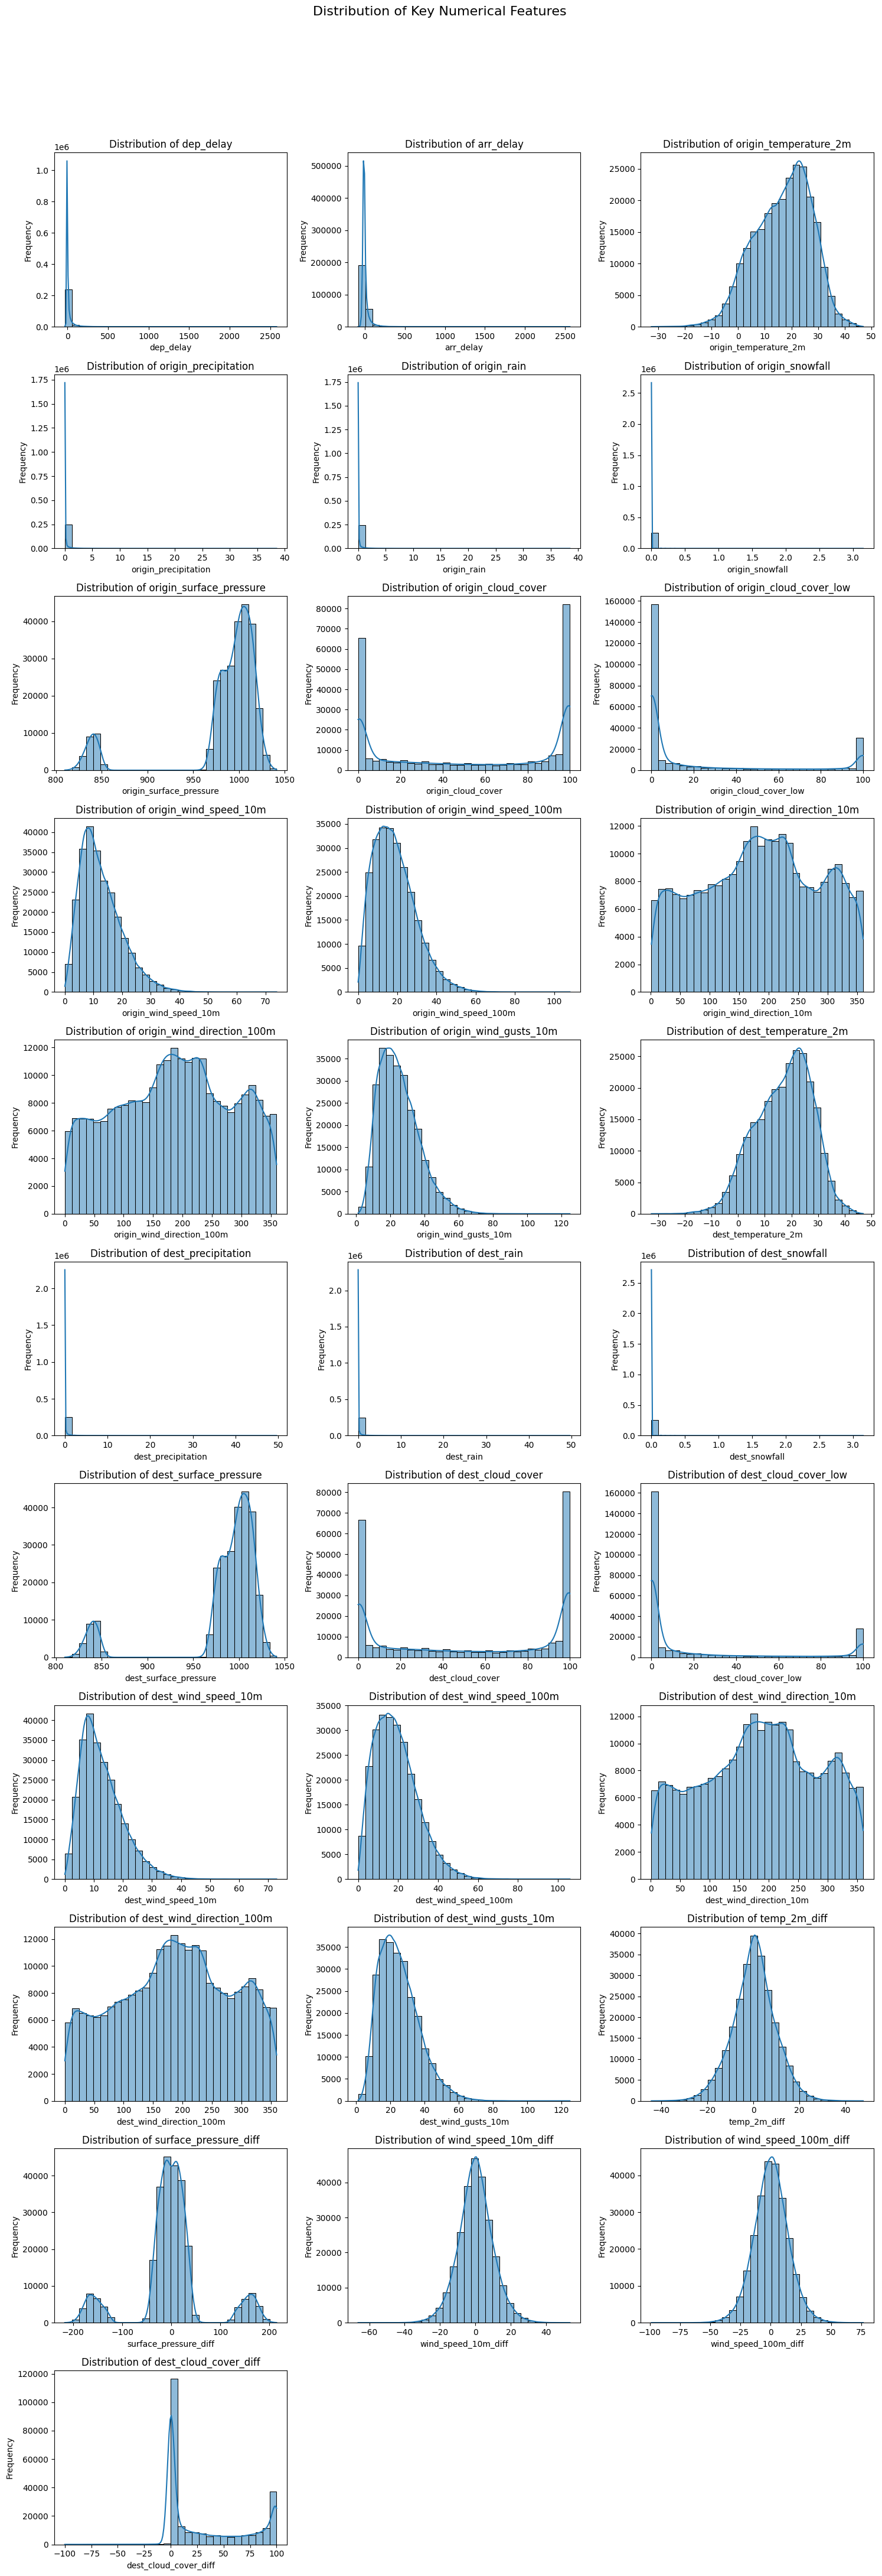

PASS: Histograms generated for key numerical features.


In [120]:
import matplotlib.pyplot as plt
import seaborn as sns

print("\n=== 6. DATA DISTRIBUTION VISUALIZATION ===")

columns_to_visualize = [
    'dep_delay',
    'arr_delay',
    'origin_temperature_2m',
    'origin_precipitation',
    'origin_rain',
    'origin_snowfall',
    'origin_weather_code_code',
    'origin_surface_pressure',
    'origin_cloud_cover',
    'origin_cloud_cover_low',
    'origin_wind_speed_10m',
    'origin_wind_speed_100m',
    'origin_wind_direction_10m',
    'origin_wind_direction_100m',
    'origin_wind_gusts_10m',
    'dest_temperature_2m',
    'dest_precipitation',
    'dest_rain',
    'dest_snowfall',
    'dest_weather_code_code',
    'dest_surface_pressure',
    'dest_cloud_cover',
    'dest_cloud_cover_low',
    'dest_wind_speed_10m',
    'dest_wind_speed_100m',
    'dest_wind_direction_10m',
    'dest_wind_direction_100m',
    'dest_wind_gusts_10m',
    'temp_2m_diff',
    'surface_pressure_diff',
    'wind_speed_10m_diff',
    'wind_speed_100m_diff',
    'dest_cloud_cover_diff'
]

with psycopg2.connect(**conn_args_from_env()) as conn:
    cols_df = pd.read_sql_query(
        """
        SELECT column_name
        FROM information_schema.columns
        WHERE table_schema = 'stg'
          AND table_name = 'flights_weather_merged'
        """,
        conn
    )

existing_columns = [c for c in columns_to_visualize if c in cols_df["column_name"].tolist()]

if not existing_columns:
    print("No selected columns found in the DataFrame to visualize.")
else:
    cols_sql = ", ".join(f'"{c}"' for c in existing_columns)
    query = f"SELECT {cols_sql} FROM stg.flights_weather_merged"

    with psycopg2.connect(**conn_args_from_env()) as conn:
        final_merged_df = pd.read_sql_query(query, conn)

    n_cols = 3
    n_rows = (len(existing_columns) + n_cols - 1) // n_cols

    plt.figure(figsize=(n_cols * 5, n_rows * 4))
    plt.suptitle('Distribution of Key Numerical Features', y=1.02, fontsize=16)

    for i, col in enumerate(existing_columns):
        plt.subplot(n_rows, n_cols, i + 1)
        sns.histplot(final_merged_df[col], kde=True, bins=30)
        plt.title(f'Distribution of {col}')
        plt.xlabel(col)
        plt.ylabel('Frequency')

    plt.tight_layout(rect=[0, 0.03, 1, 0.98])
    plt.show()
    print("PASS: Histograms generated for key numerical features.")


# Save to Data Warehouse

In [121]:
with psycopg2.connect(**conn_args_from_env()) as conn:
    with conn.cursor() as cur:
        cur.execute("CREATE SCHEMA IF NOT EXISTS gold;")
        cur.execute("DROP TABLE IF EXISTS gold.final_merged;")
        cur.execute("CREATE TABLE gold.final_merged AS SELECT * FROM stg.flights_weather_merged;")
    conn.commit()

In [6]:

with psycopg2.connect(**conn_args_from_env()) as conn:
    with conn.cursor() as cur:
        cur.execute("DROP TABLE IF EXISTS gold.final_merged_star;")
        cur.execute("CREATE TABLE gold.final_merged_star AS SELECT * FROM gold.final_merged;")
    conn.commit()

with psycopg2.connect(**conn_args_from_env()) as conn:
    df = pd.read_sql_query("SELECT * FROM gold.final_merged_star", conn)

df.info()


C:\Users\ryand\AppData\Local\Temp\ipykernel_25540\999936130.py:8: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query("SELECT * FROM gold.final_merged_star", conn)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 255119 entries, 0 to 255118
Data columns (total 72 columns):
 #   Column                      Non-Null Count   Dtype         
---  ------                      --------------   -----         
 0   fl_date                     255119 non-null  int64         
 1   airline                     255119 non-null  object        
 2   airline_code                255119 non-null  object        
 3   dot_code                    255119 non-null  float64       
 4   fl_number                   255119 non-null  float64       
 5   origin                      255119 non-null  object        
 6   origin_city                 255119 non-null  object        
 7   dest                        255119 non-null  object        
 8   dest_city                   255119 non-null  object        
 9   crs_dep_time                255119 non-null  float64       
 10  dep_time                    255119 non-null  int64         
 11  dep_delay                   255119 non-

## Create Star Schema

In [7]:
sql_statements = [
    # schema
    "CREATE SCHEMA IF NOT EXISTS gold_star",

    # dim_date
    "DROP TABLE IF EXISTS gold_star.dim_date CASCADE",
    """
    CREATE TABLE gold_star.dim_date (
      date_key BIGINT PRIMARY KEY,
      date_value DATE,
      year INT,
      month INT,
      day INT,
      day_of_week INT
    )
    """,
    """
    INSERT INTO gold_star.dim_date (date_key, date_value, year, month, day, day_of_week)
    SELECT DISTINCT
      fl_date AS date_key,
      TO_DATE(fl_date::text, 'YYYYMMDD') AS date_value,
      EXTRACT(YEAR FROM TO_DATE(fl_date::text, 'YYYYMMDD'))::int,
      EXTRACT(MONTH FROM TO_DATE(fl_date::text, 'YYYYMMDD'))::int,
      EXTRACT(DAY FROM TO_DATE(fl_date::text, 'YYYYMMDD'))::int,
      EXTRACT(DOW FROM TO_DATE(fl_date::text, 'YYYYMMDD'))::int
    FROM gold.final_merged
    WHERE fl_date IS NOT NULL
    """,

    # dim_time
    "DROP TABLE IF EXISTS gold_star.dim_time CASCADE",
    """
    CREATE TABLE gold_star.dim_time (
      time_key INT PRIMARY KEY,
      hour INT,
      minute INT
    )
    """,
    """
    INSERT INTO gold_star.dim_time (time_key, hour, minute)
    SELECT DISTINCT
      time_key,
      (time_key / 100)::int AS hour,
      (time_key % 100)::int AS minute
    FROM (
      SELECT crs_dep_time_rounded::int AS time_key FROM gold.final_merged
      UNION
      SELECT crs_arr_time_rounded::int AS time_key FROM gold.final_merged
    ) t
    WHERE time_key IS NOT NULL
    """,

    # dim_airline
    "DROP TABLE IF EXISTS gold_star.dim_airline CASCADE",
    """
    CREATE TABLE gold_star.dim_airline (
      airline_key BIGSERIAL PRIMARY KEY,
      airline_code TEXT UNIQUE,
      airline TEXT,
      airlines_encode BIGINT,
      airline_code_encode BIGINT
    )
    """,
    """
    INSERT INTO gold_star.dim_airline (airline_code, airline, airlines_encode, airline_code_encode)
    SELECT DISTINCT
      airline_code, airline, airlines_encode, airline_code_encode
    FROM gold.final_merged
    """,

    # dim_airport
    "DROP TABLE IF EXISTS gold_star.dim_airport CASCADE",
    """
    CREATE TABLE gold_star.dim_airport (
      airport_key BIGSERIAL PRIMARY KEY,
      airport_code TEXT UNIQUE,
      city_name TEXT,
      city_location_id BIGINT
    )
    """,
    """
    INSERT INTO gold_star.dim_airport (airport_code, city_name, city_location_id)
    SELECT DISTINCT origin, origin_city, origin_cities_encode FROM gold.final_merged
    UNION
    SELECT DISTINCT dest, dest_city, dest_cities_encode FROM gold.final_merged
    """,

    # dim_weather
    "DROP TABLE IF EXISTS gold_star.dim_weather CASCADE",
    """
    CREATE TABLE gold_star.dim_weather (
      weather_key BIGSERIAL PRIMARY KEY,
      location_id BIGINT,
      date_key BIGINT REFERENCES gold_star.dim_date(date_key),
      time_key INT REFERENCES gold_star.dim_time(time_key),
      obs_time TIMESTAMP,
      temperature_2m DOUBLE PRECISION,
      precipitation DOUBLE PRECISION,
      rain DOUBLE PRECISION,
      snowfall DOUBLE PRECISION,
      weather_code DOUBLE PRECISION,
      surface_pressure DOUBLE PRECISION,
      cloud_cover DOUBLE PRECISION,
      cloud_cover_low DOUBLE PRECISION,
      wind_speed_10m DOUBLE PRECISION,
      wind_speed_100m DOUBLE PRECISION,
      wind_direction_10m DOUBLE PRECISION,
      wind_direction_100m DOUBLE PRECISION,
      wind_gusts_10m DOUBLE PRECISION
    )
    """,
    """
    INSERT INTO gold_star.dim_weather (
      location_id, date_key, time_key, obs_time,
      temperature_2m, precipitation, rain, snowfall, weather_code,
      surface_pressure, cloud_cover, cloud_cover_low,
      wind_speed_10m, wind_speed_100m, wind_direction_10m,
      wind_direction_100m, wind_gusts_10m
    )
    SELECT DISTINCT ON (location_id, "date", "time_hour_minute")
      location_id,
      "date"::bigint AS date_key,
      "time_hour_minute"::int AS time_key,
      "time" AS obs_time,
      temperature_2m, precipitation, rain, snowfall, weather_code,
      surface_pressure, cloud_cover, cloud_cover_low,
      wind_speed_10m, wind_speed_100m, wind_direction_10m,
      wind_direction_100m, wind_gusts_10m
    FROM stg.weather_standardized
    ORDER BY location_id, "date", "time_hour_minute", "time"
    """,

    # fact_flight
    "DROP TABLE IF EXISTS gold_star.fact_flight CASCADE",
    """
    CREATE TABLE gold_star.fact_flight (
      flight_key BIGSERIAL PRIMARY KEY,

      date_key BIGINT REFERENCES gold_star.dim_date(date_key),
      airline_key BIGINT REFERENCES gold_star.dim_airline(airline_key),
      origin_airport_key BIGINT REFERENCES gold_star.dim_airport(airport_key),
      dest_airport_key BIGINT REFERENCES gold_star.dim_airport(airport_key),
      dep_time_key INT REFERENCES gold_star.dim_time(time_key),
      arr_time_key INT REFERENCES gold_star.dim_time(time_key),
      origin_weather_key BIGINT REFERENCES gold_star.dim_weather(weather_key),
      dest_weather_key BIGINT REFERENCES gold_star.dim_weather(weather_key),

      fl_number NUMERIC,
      dot_code NUMERIC,
      crs_dep_time NUMERIC,
      crs_arr_time NUMERIC,

      dep_time BIGINT,
      dep_delay BIGINT,
      taxi_out BIGINT,
      wheels_off BIGINT,
      wheels_on BIGINT,
      taxi_in BIGINT,
      arr_time BIGINT,
      arr_delay BIGINT,
      cancelled BIGINT,
      diverted BIGINT,
      crs_elapsed_time BIGINT,
      elapsed_time BIGINT,
      air_time BIGINT,
      distance BIGINT,

      delay_due_carrier BIGINT,
      delay_due_weather BIGINT,
      delay_due_nas BIGINT,
      delay_due_security BIGINT,
      delay_due_late_aircraft BIGINT,

      temp_2m_diff DOUBLE PRECISION,
      surface_pressure_diff DOUBLE PRECISION,
      wind_speed_10m_diff DOUBLE PRECISION,
      wind_speed_100m_diff DOUBLE PRECISION,
      dest_cloud_cover_diff DOUBLE PRECISION
    )
    """,
    """
    INSERT INTO gold_star.fact_flight (
      date_key, airline_key, origin_airport_key, dest_airport_key,
      dep_time_key, arr_time_key, origin_weather_key, dest_weather_key,
      fl_number, dot_code, crs_dep_time, crs_arr_time,
      dep_time, dep_delay, taxi_out, wheels_off, wheels_on, taxi_in,
      arr_time, arr_delay, cancelled, diverted,
      crs_elapsed_time, elapsed_time, air_time, distance,
      delay_due_carrier, delay_due_weather, delay_due_nas, delay_due_security, delay_due_late_aircraft,
      temp_2m_diff, surface_pressure_diff, wind_speed_10m_diff, wind_speed_100m_diff, dest_cloud_cover_diff
    )
    SELECT
      d.date_key,
      a.airline_key,
      ao.airport_key AS origin_airport_key,
      ad.airport_key AS dest_airport_key,
      dt_dep.time_key AS dep_time_key,
      dt_arr.time_key AS arr_time_key,
      wo.weather_key AS origin_weather_key,
      wd.weather_key AS dest_weather_key,

      f.fl_number, f.dot_code, f.crs_dep_time, f.crs_arr_time,
      f.dep_time, f.dep_delay, f.taxi_out, f.wheels_off, f.wheels_on, f.taxi_in,
      f.arr_time, f.arr_delay, f.cancelled, f.diverted,
      f.crs_elapsed_time, f.elapsed_time, f.air_time, f.distance,
      f.delay_due_carrier, f.delay_due_weather, f.delay_due_nas, f.delay_due_security, f.delay_due_late_aircraft,
      f.temp_2m_diff, f.surface_pressure_diff, f.wind_speed_10m_diff, f.wind_speed_100m_diff, f.dest_cloud_cover_diff
    FROM gold.final_merged f
    LEFT JOIN gold_star.dim_date d ON d.date_key = f.fl_date
    LEFT JOIN gold_star.dim_airline a ON a.airline_code = f.airline_code
    LEFT JOIN gold_star.dim_airport ao ON ao.airport_code = f.origin
    LEFT JOIN gold_star.dim_airport ad ON ad.airport_code = f.dest
    LEFT JOIN gold_star.dim_time dt_dep ON dt_dep.time_key = f.crs_dep_time_rounded::int
    LEFT JOIN gold_star.dim_time dt_arr ON dt_arr.time_key = f.crs_arr_time_rounded::int
    LEFT JOIN gold_star.dim_weather wo
      ON wo.location_id = f.origin_cities_encode
     AND wo.date_key = f.fl_date
     AND wo.time_key = f.crs_dep_time_rounded::int
    LEFT JOIN gold_star.dim_weather wd
      ON wd.location_id = f.dest_cities_encode
     AND wd.date_key = f.fl_date
     AND wd.time_key = f.crs_arr_time_rounded::int
    """,
]

with psycopg2.connect(**conn_args_from_env()) as conn:
    with conn.cursor() as cur:
        for stmt in sql_statements:
            cur.execute(stmt)
    conn.commit()
